In [2]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH '] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import cv2
import json
from PIL import Image

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,BatchNormalization,GlobalAveragePooling2D,Input,concatenate
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import precision_recall_curve

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
!nvidia-smi

Num GPUs Available:  1
Thu Dec 21 14:36:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 546.17       CUDA Version: 12.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| N/A   37C    P8     2W / 140W |    102MiB /  8188MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                 

In [80]:
class_names = ["signature", "stamp", "logo", "text"]
errors = []
for name in tqdm(class_names):
    images = os.listdir(f"SPODS_Dataset/")
    count = 0
    for image in images:
        try:
            axis = pd.read_csv("signture axis/" + image[:-4].replace(" ","") + ".csv")
            axis = axis.iloc[class_names.index(name)].values[5]
            axis = json.loads(axis)
            img = cv2.imread(f"SPODS_Dataset/"+image)
            img = img[axis["y"]:axis["y"]+axis["height"], axis["x"]:axis["x"]+axis["width"]]
            ones = np.count_nonzero(img)
            if ones < 0:
                errors.append(f"{name}     :      ||     {image}     ||     ones_count")
            else:
                cv2.imwrite(f"Dataset/{name}/{count}.png", img)
                count += 1
        except Exception as e:
            errors.append(f"{name}     :      ||     {image}     ||     missing axis" + str(e))
            pass
print("Done")
print("Errors : " + f"{len(errors)}")
for error in errors:
    print(error)

100%|██████████| 4/4 [03:08<00:00, 47.25s/it]

Done
Errors : 34
signature     :      ||     image (528).png     ||     missing axissingle positional indexer is out-of-bounds
stamp     :      ||     image (528).png     ||     missing axissingle positional indexer is out-of-bounds
logo     :      ||     image (1059).png     ||     missing axissingle positional indexer is out-of-bounds
logo     :      ||     image (1058).png     ||     missing axissingle positional indexer is out-of-bounds
logo     :      ||     image (1060).png     ||     missing axissingle positional indexer is out-of-bounds
logo     :      ||     image (528).png     ||     missing axissingle positional indexer is out-of-bounds
logo     :      ||     image (1072).png     ||     missing axissingle positional indexer is out-of-bounds
logo     :      ||     image (1063).png     ||     missing axissingle positional indexer is out-of-bounds
logo     :      ||     image (1065).png     ||     missing axissingle positional indexer is out-of-bounds
logo     :      ||     ima

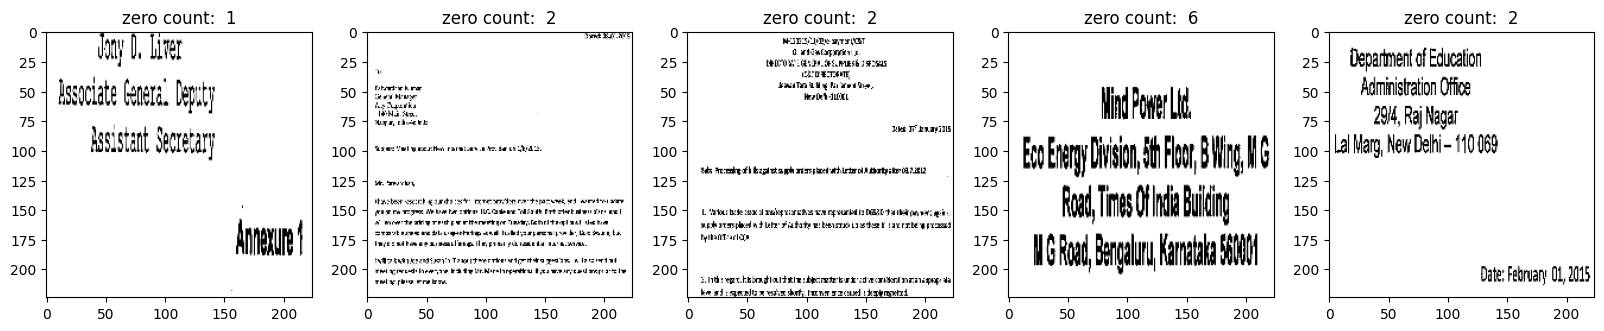

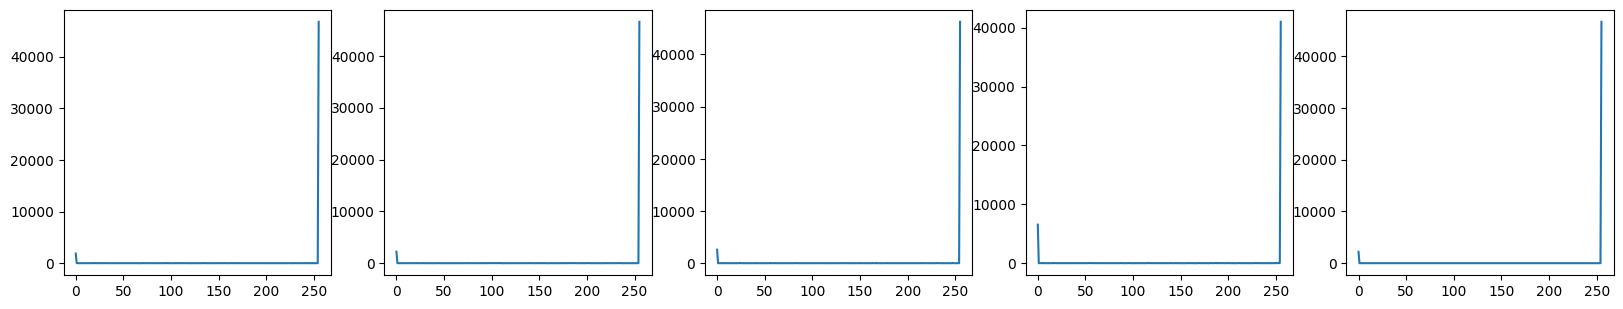

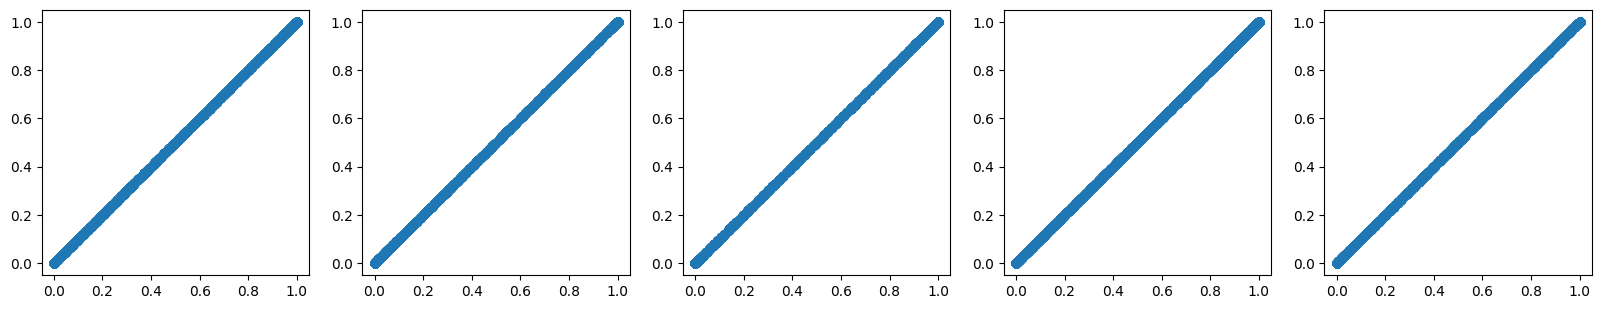

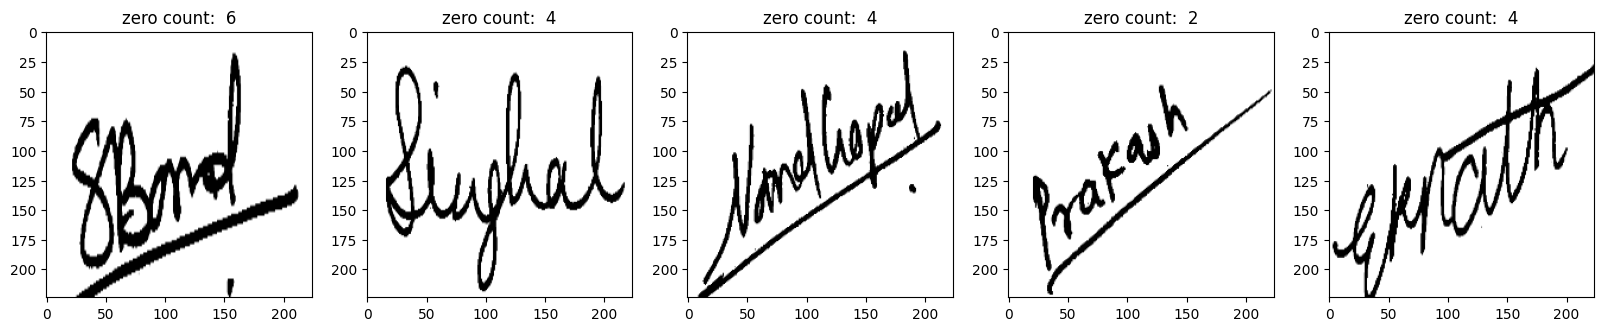

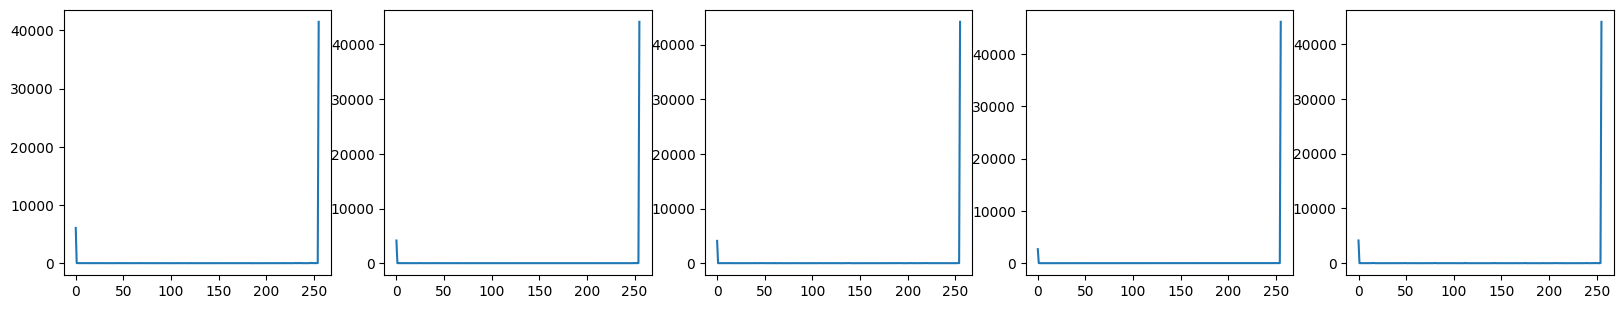

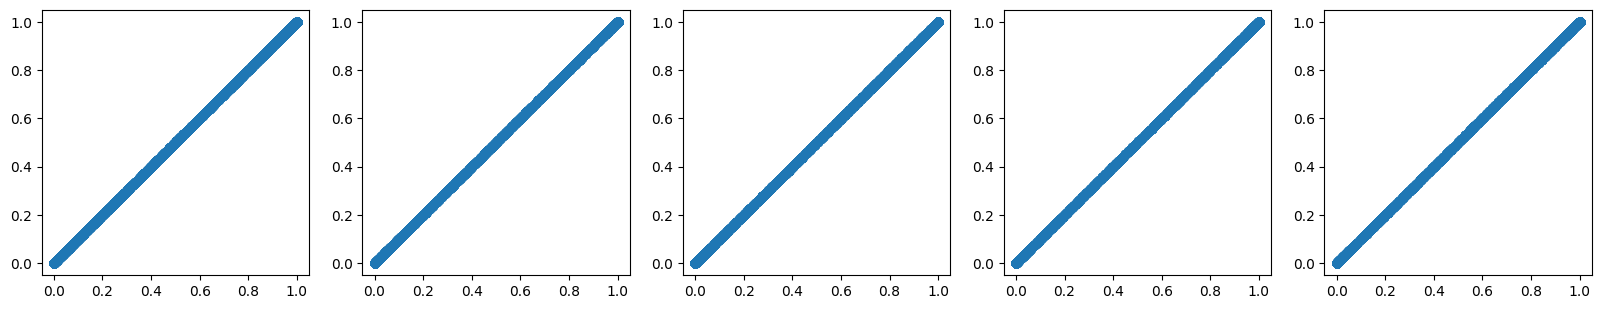

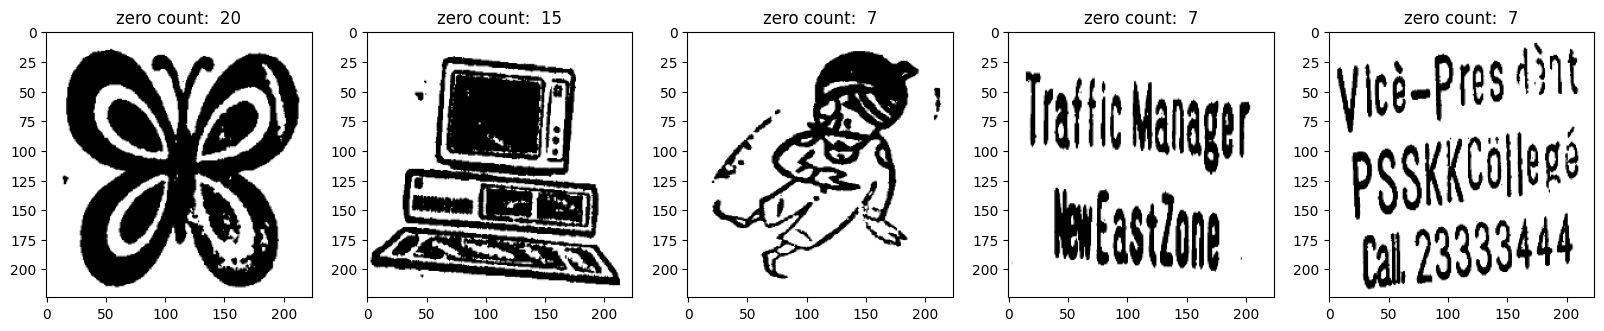

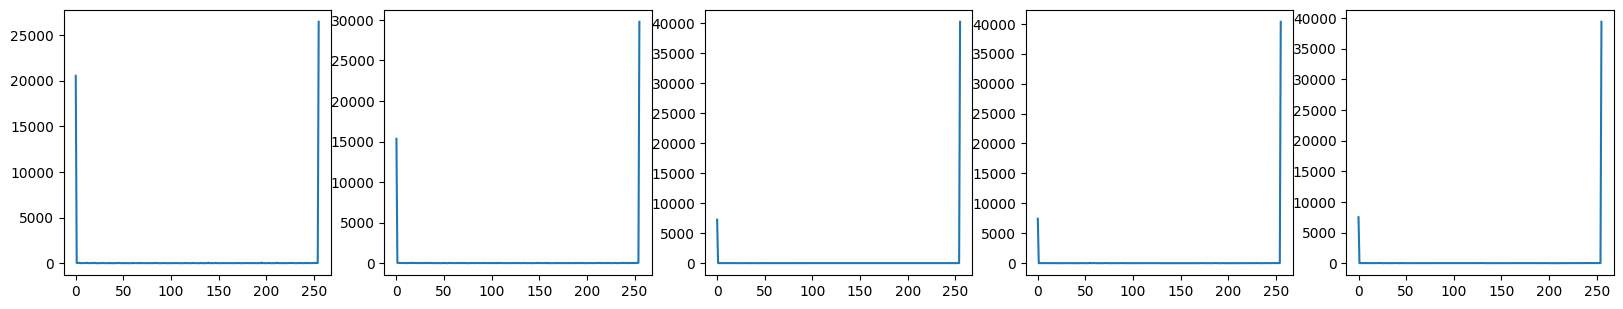

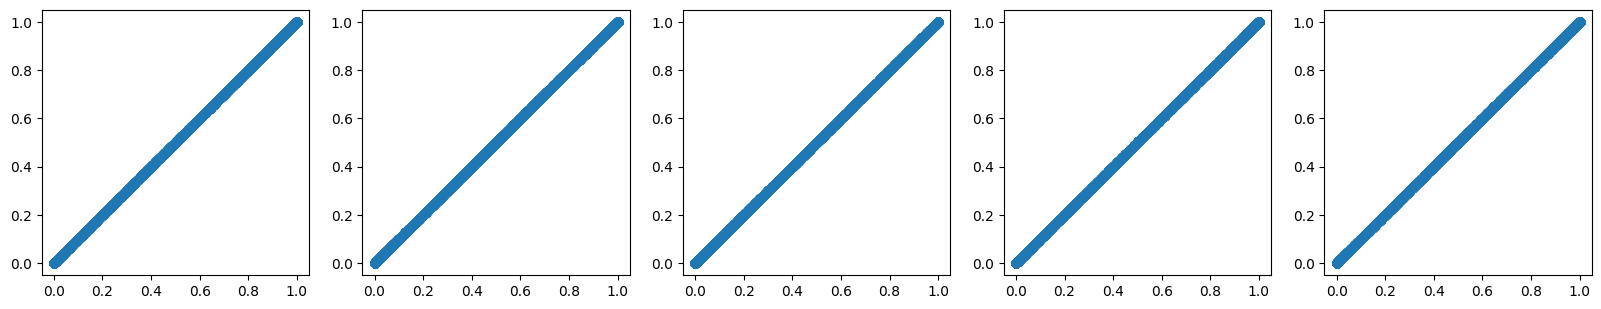

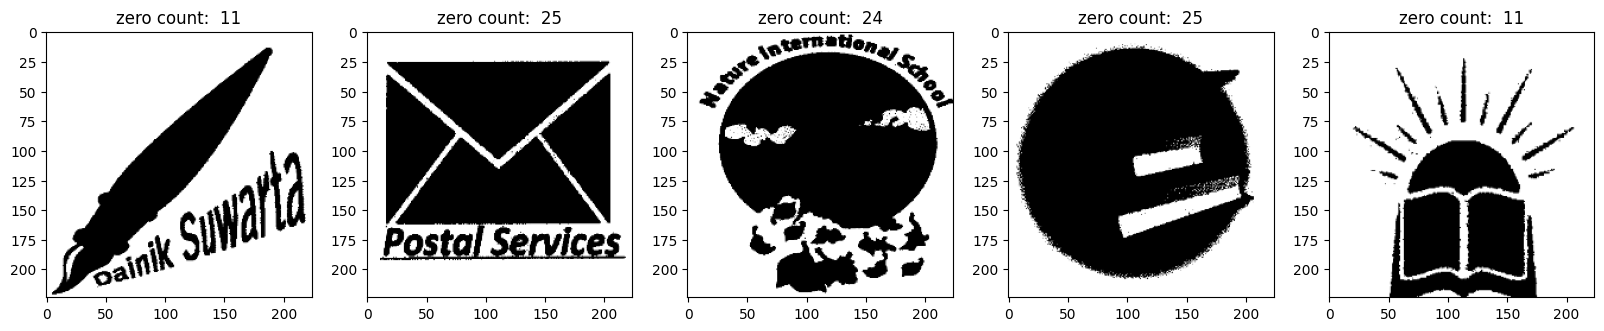

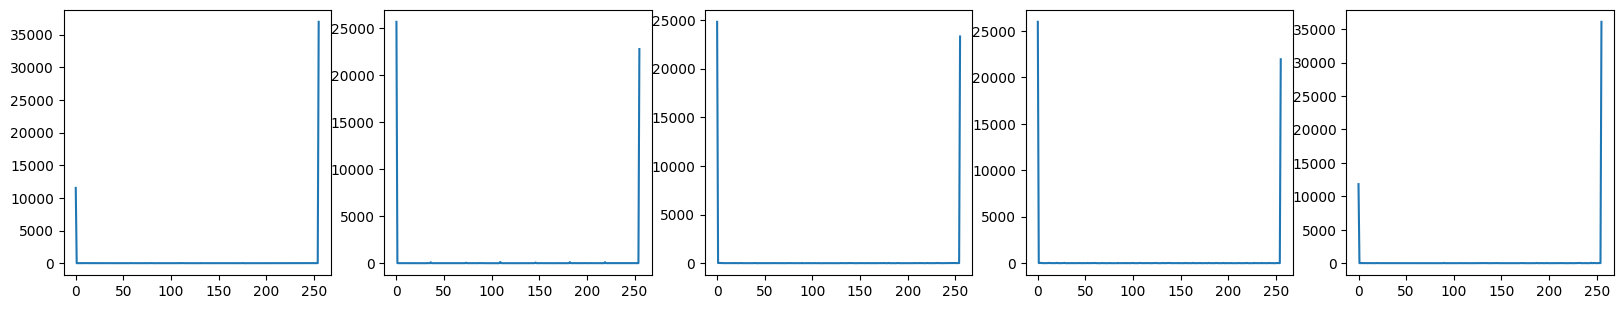

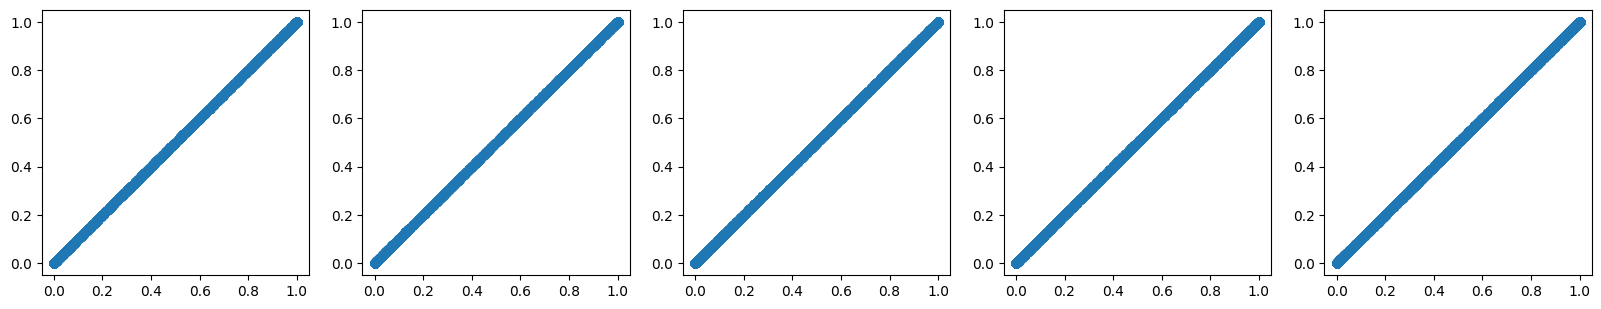

In [5]:
paths = ["Dataset/text","Dataset/signature", "Dataset/stamp","Dataset/logo"]

pixels_pos = []
for path in paths:
    photos = os.listdir(path)
    plt.figure(figsize=(20, 20))
    for i in range(0, 5):
        plt.subplot(5, 5, i+1)
        img = plt.imread(path + "//" + photos[i])
        # convert to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (224, 224))
        plt.imshow(img, cmap="gray")
        psum = np.sum(img)
        zero_count = np.count_nonzero(img == 0)
        plt.title("zero count: " + f" {zero_count//1000}")
        # plt.axis("off")
    plt.show()


    plt.figure(figsize=(20, 20))
    for i in range(0, 5):
        plt.subplot(5, 5, i+1)
        img = cv2.imread(path + "//" + photos[i])
        img = cv2.resize(img, (224, 224))
        hist = cv2.calcHist([img], [0], None, [256], [0, 256])
        # print(hist.ravel())
        plt.plot(hist.ravel())
        # plt.axis("off")
    plt.show()

    
    plt.figure(figsize=(20, 20))
    for i in range(0, 5):
        plt.subplot(5, 5, i+1)
        img = plt.imread(path + "//" + photos[i])
        img = cv2.resize(img, (224, 224))
        plt.scatter(img[:, :, 0].ravel(), img[:, :, 1].ravel())
        # plt.axis("off")
    plt.show()


In [3]:
dataset_path = "Dataset"
class_names = ["signature", "stamp", "logo", "text"]
image_data = []
hist_data = []
labels = []

for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    for image_file in tqdm(os.listdir(class_path)):
        image_path = os.path.join(class_path, image_file)
        image = cv2.imread(image_path)
        image = cv2.resize(image,(224, 224))
        hist = cv2.calcHist([image], [0], None, [256], [0, 256])        
        image_data.append(image)
        hist_data.append(hist.ravel())
        labels.append(class_names.index(class_folder))
        
image_data = np.array(image_data)
hist_data = np.array(hist_data)
labels = np.array(labels)
labels = to_categorical(labels, num_classes=4)

100%|██████████| 1079/1079 [00:01<00:00, 619.83it/s]


In [4]:
x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)
xh_train, xh_test = train_test_split(hist_data,test_size=0.2, random_state=42)

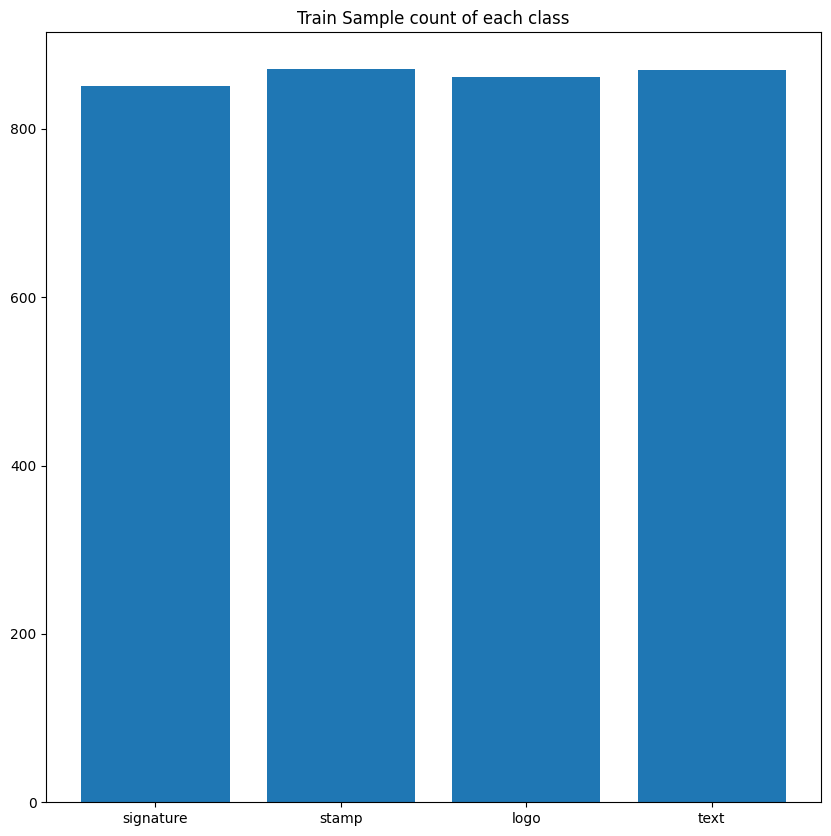

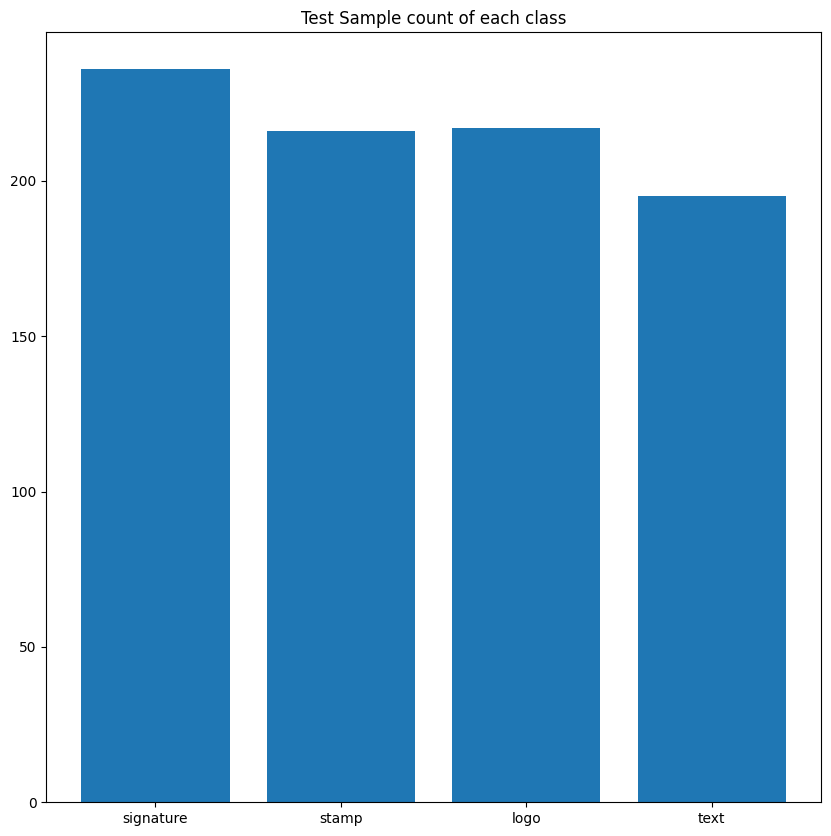

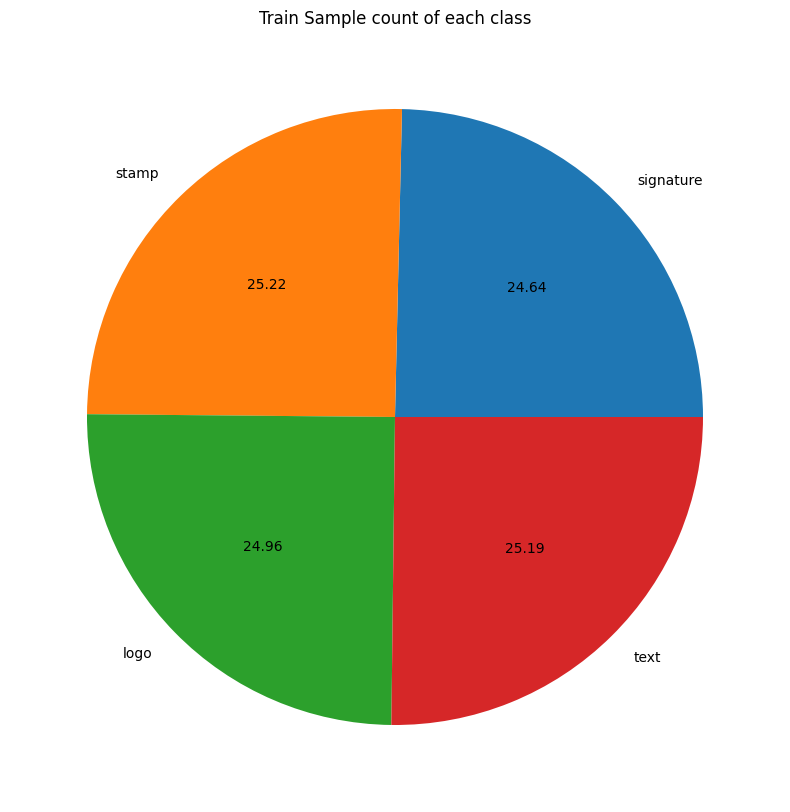

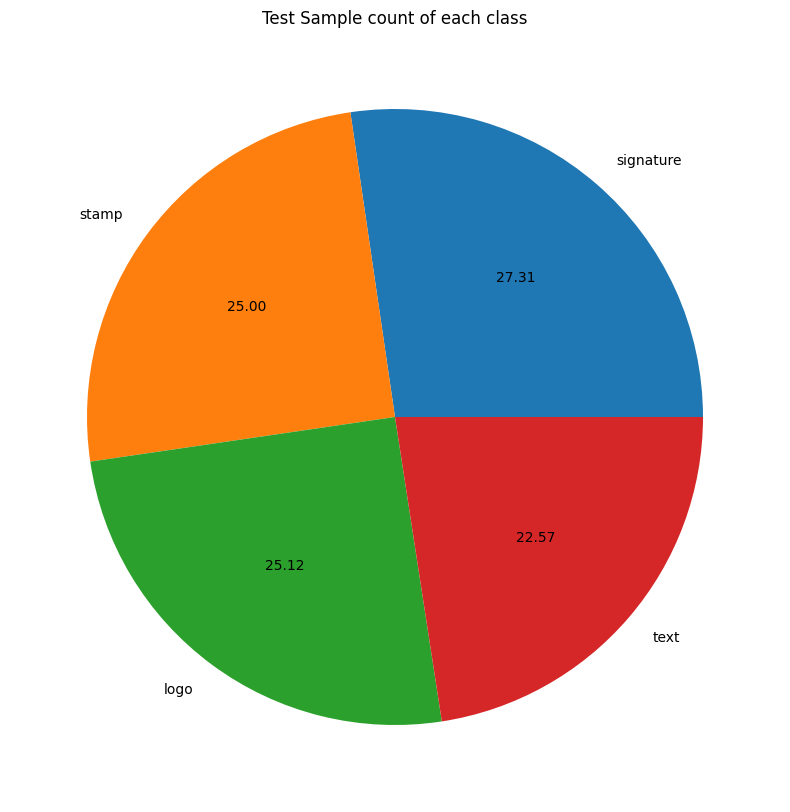

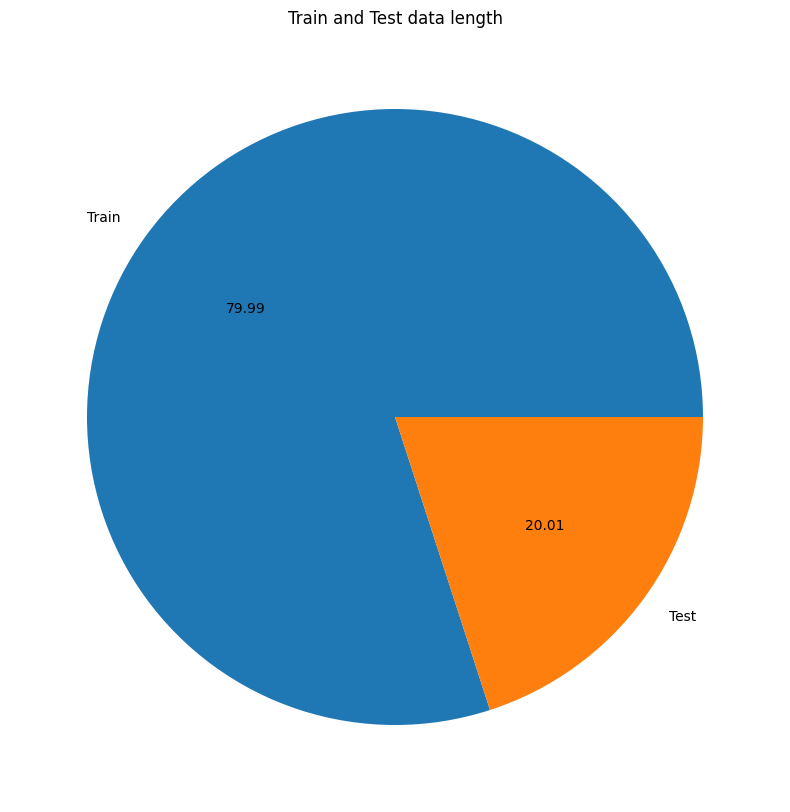

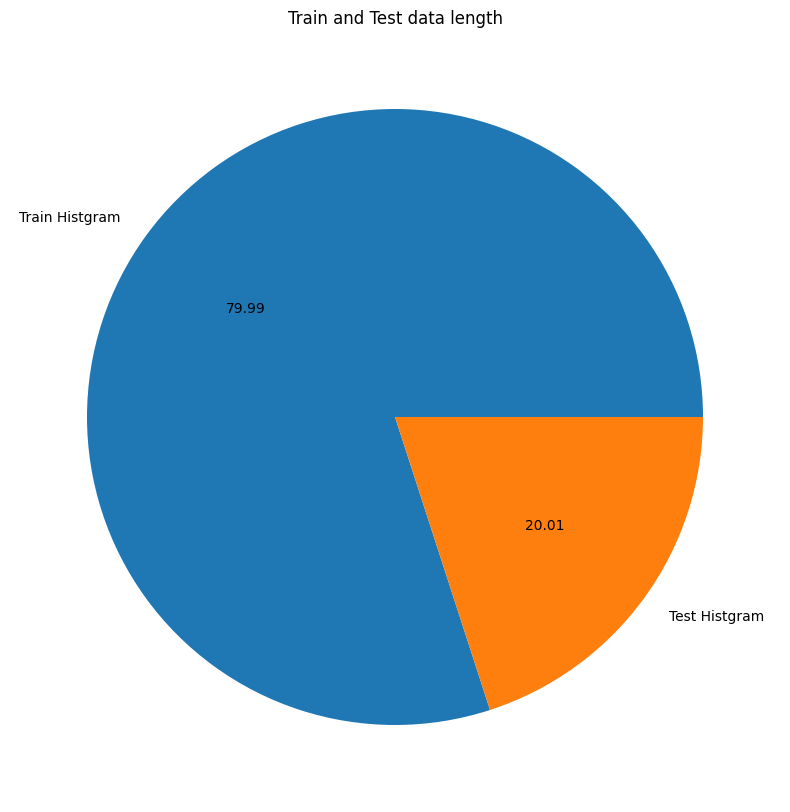

In [11]:
# display the sample count of each class with a bar graph
plt.figure(figsize=(10, 10))
plt.bar(x=class_names, height=np.bincount(y_train.argmax(axis=1)))
plt.title("Train Sample count of each class")
plt.show()

# display the sample count of each class with a bar graph
plt.figure(figsize=(10, 10))
plt.bar(x=class_names, height=np.bincount(y_test.argmax(axis=1)))
plt.title("Test Sample count of each class")
plt.show()


plt.figure(figsize=(10, 10))
plt.pie(x=np.bincount(y_train.argmax(axis=1)), labels=class_names, autopct="%.2f")
plt.title("Train Sample count of each class")
plt.show()


plt.figure(figsize=(10, 10))
plt.pie(x=np.bincount(y_test.argmax(axis=1)), labels=class_names, autopct="%.2f")
plt.title("Test Sample count of each class")
plt.show()


# len of train and test data as a pie chart
plt.figure(figsize=(10, 10))
plt.pie(x=[len(x_train), len(x_test)], labels=["Train", "Test"], autopct="%.2f")
plt.title("Train and Test data length")
plt.show()

plt.figure(figsize=(10, 10))
plt.pie(x=[len(xh_train), len(xh_test)], labels=["Train Histgram", "Test Histgram"], autopct="%.2f")
plt.title("Train and Test data length")
plt.show()

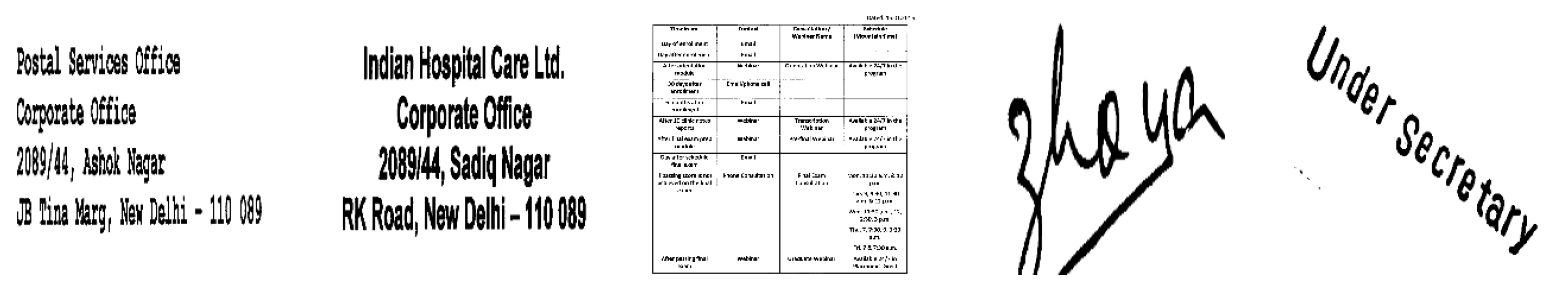

In [52]:
# show some images
plt.figure(figsize=(20, 20))
for i in range(0, 5):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_train[np.random.randint(0, x_train.shape[0])], cmap="gray")
    plt.axis("off")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 220, 220, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 110, 110, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 108, 108, 32)      9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 106, 106, 32)     

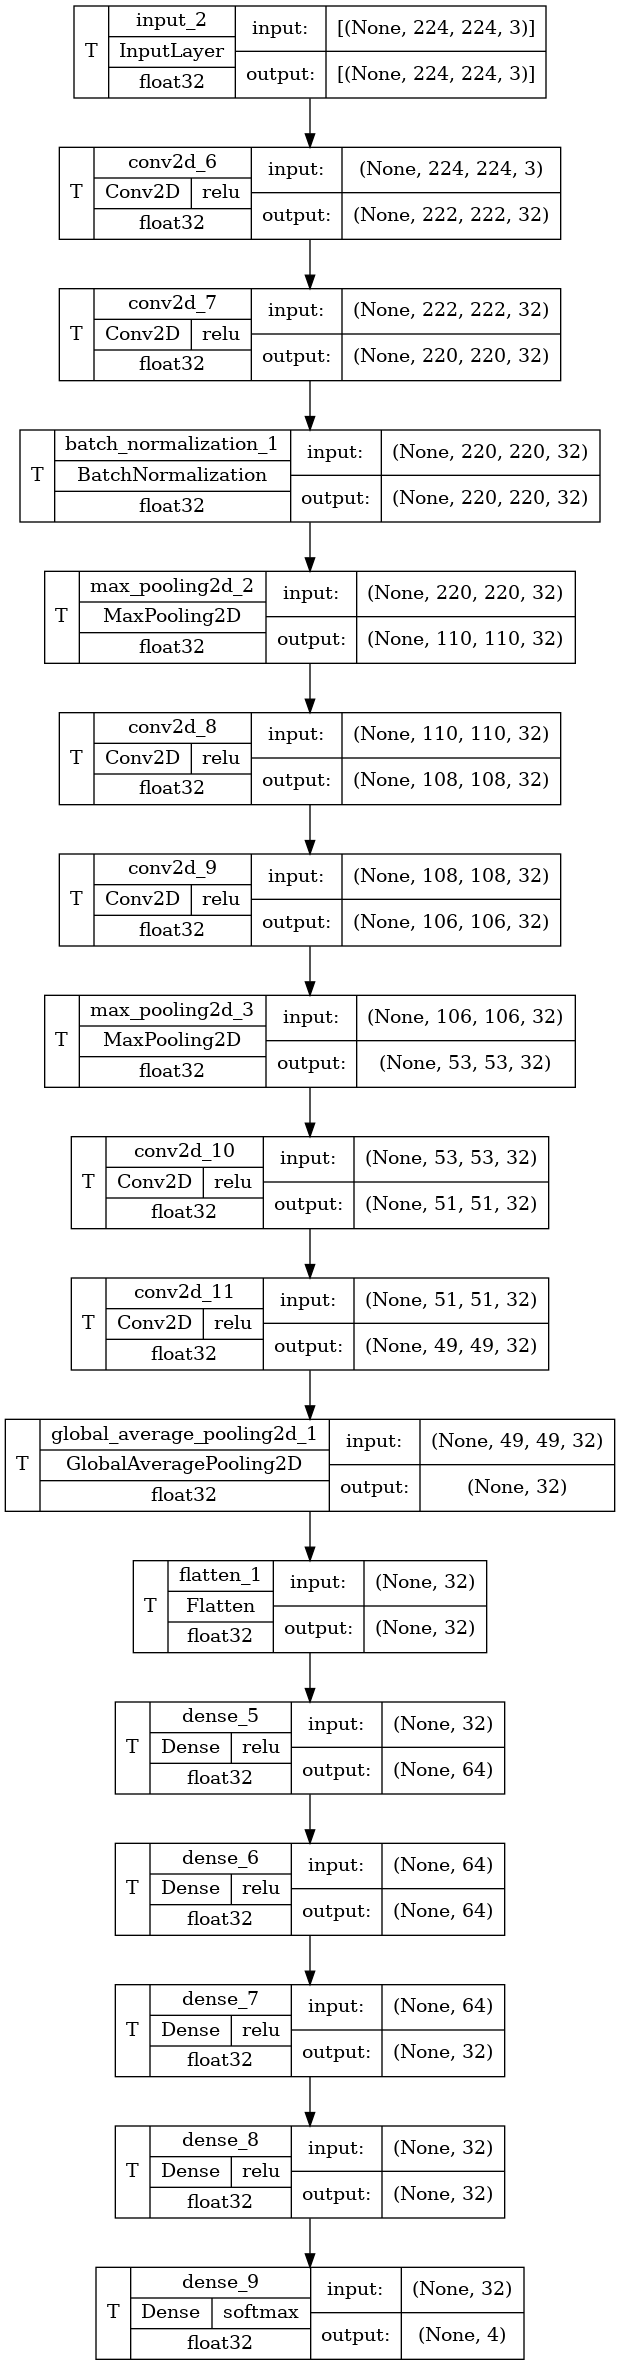

In [8]:
model = Sequential()
model.add(Input(shape=(224, 224,3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,show_dtype=True,show_layer_activations=True,show_trainable=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 222, 222, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 220, 220, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 220, 220, 32)         128       ['conv2d_1[0][0]']            
 Normalization)                                                                               

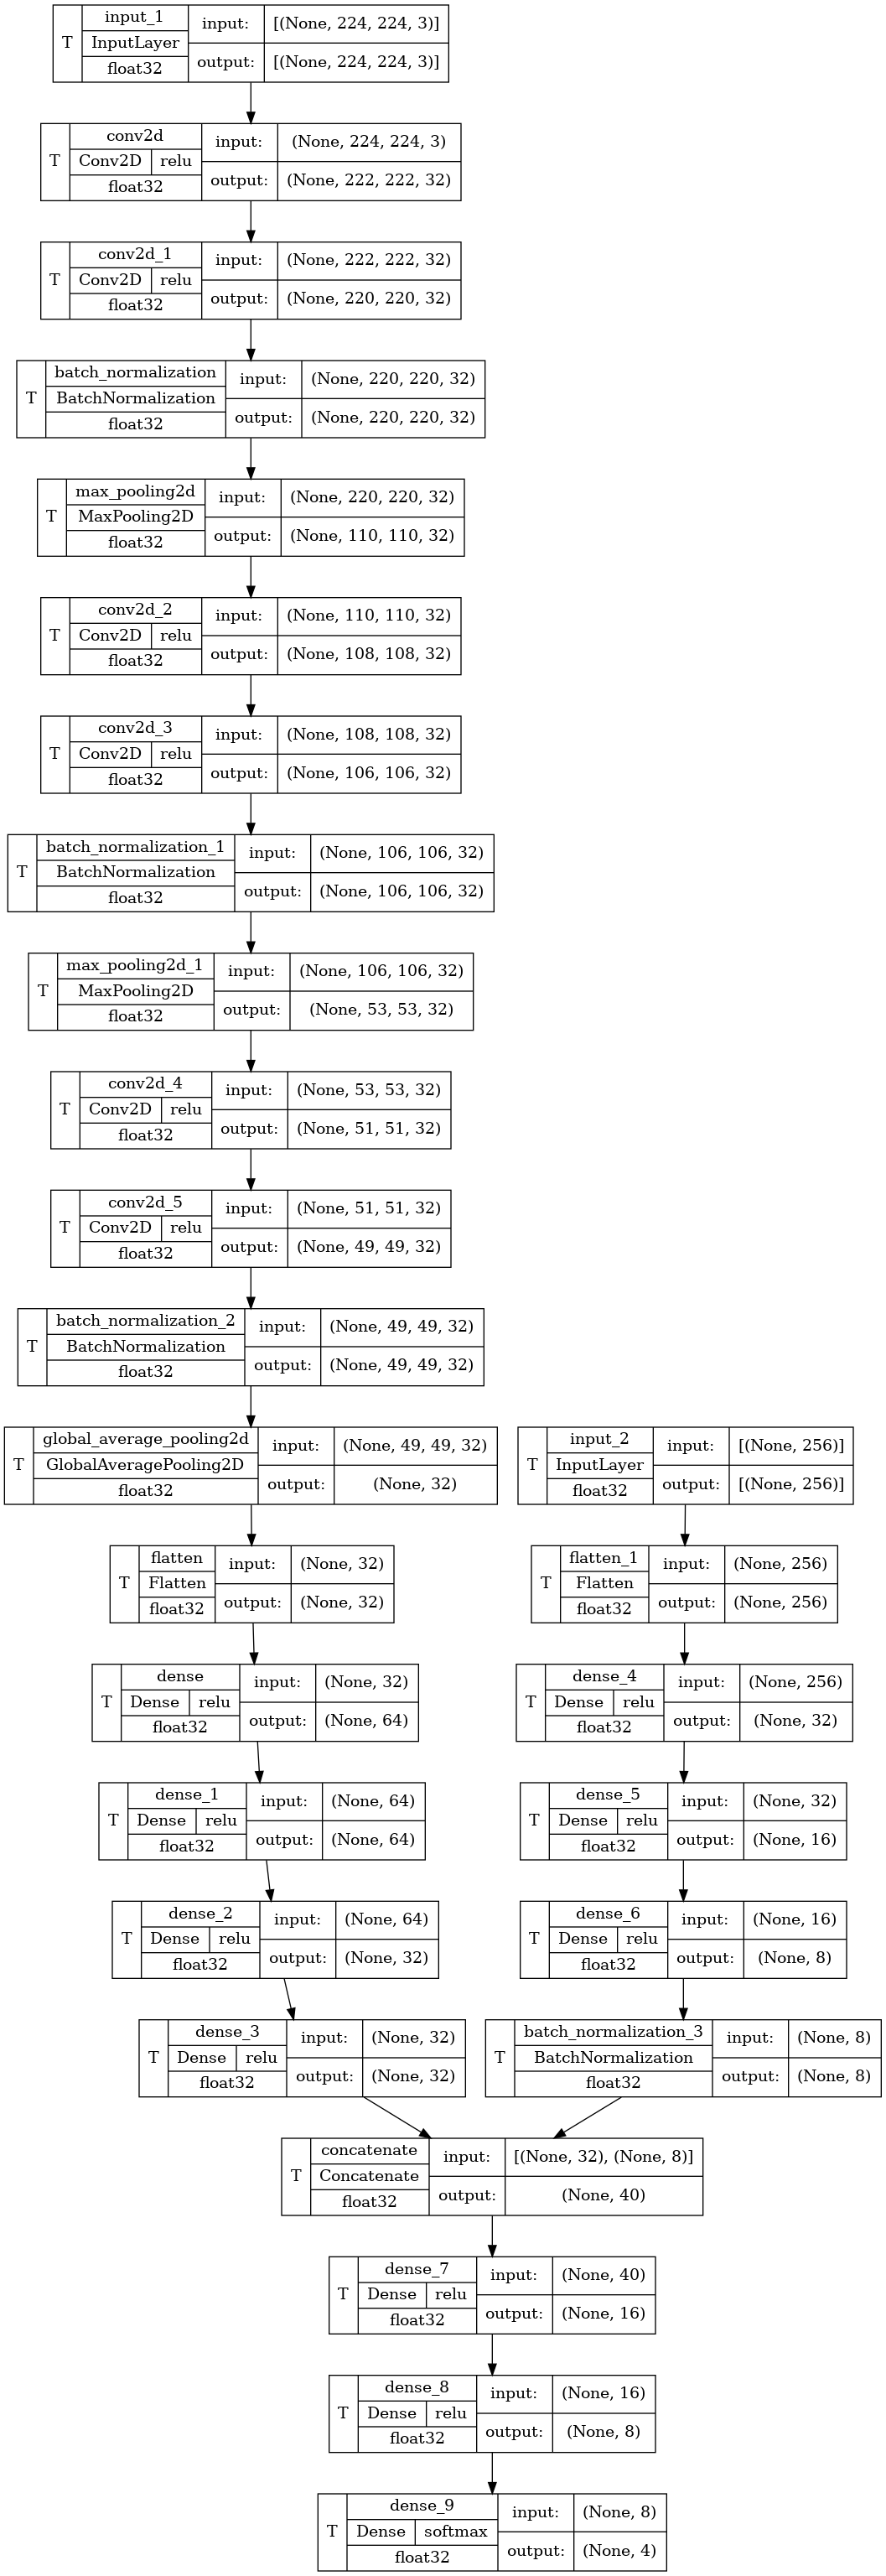

In [5]:
def build_model(input_shape=(224, 224, 3),hist=(256))->Model:
     input_layer_image = Input(shape=input_shape)
     input_layer_hist = Input(hist)
     # image part
     x1 = Conv2D(32, (3, 3), activation='relu')(input_layer_image)
     x1 = Conv2D(32, (3, 3), activation='relu')(x1)
     x1 = BatchNormalization()(x1)
     x1 = MaxPooling2D((2, 2))(x1)
     x1 = Conv2D(32, (3, 3), activation='relu')(x1)
     x1 = Conv2D(32, (3, 3), activation='relu')(x1)
     x1 = BatchNormalization()(x1)
     x1 = MaxPooling2D((2, 2))(x1)
     x1 = Conv2D(32, (3, 3), activation='relu')(x1)
     x1 = Conv2D(32, (3, 3), activation='relu')(x1)
     x1 = BatchNormalization()(x1)
     x1 = GlobalAveragePooling2D()(x1)
     x1 = Flatten()(x1)
     x1 = Dense(64, activation='relu')(x1)
     x1 = Dense(64, activation='relu')(x1)
     x1 = Dense(32, activation='relu')(x1)
     x1 = Dense(32, activation='relu')(x1)
    #  histgram part
     x2 = Flatten()(input_layer_hist)
     x2 = Dense(32, activation='relu')(x2)
     x2 = Dense(16, activation='relu')(x2)
     x2 = Dense(8, activation='relu')(x2)
     x2 = BatchNormalization()(x2)
     
     # concatenate
     x12 = concatenate([x1, x2], axis=1)
     x12 = Dense(16, activation='relu')(x12)
     x12 = Dense(8, activation='relu')(x12)
     
     x3 = Dense(4, activation='softmax')(x12)
     model = Model(inputs=[input_layer_image,input_layer_hist], outputs=x3)
     return model
    
model = build_model()
model.summary()
plot_model(model, to_file='model_with_hist_plot.png', show_shapes=True, show_layer_names=True,show_dtype=True,show_layer_activations=True,show_trainable=True)

In [6]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy","Precision", "Recall","mean_squared_error","mean_absolute_error"])

In [10]:
history = model.fit(x=x_train, y=y_train,epochs=20,validation_split=0.2,shuffle=True,validation_data=(x_test, y_test))
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history_without_hist.csv')

Epoch 1/20
108/108 [==============================] - 13s 100ms/step - loss: 0.6741 - accuracy: 0.6917 - precision: 0.8416 - recall: 0.5721 - mean_squared_error: 0.0954 - mean_absolute_error: 0.1950 - val_loss: 0.4626 - val_accuracy: 0.7940 - val_precision: 0.8040 - val_recall: 0.7836 - val_mean_squared_error: 0.0748 - val_mean_absolute_error: 0.1271
Epoch 2/20
108/108 [==============================] - 6s 56ms/step - loss: 0.3227 - accuracy: 0.8819 - precision: 0.8910 - recall: 0.8593 - mean_squared_error: 0.0446 - mean_absolute_error: 0.0921 - val_loss: 0.1612 - val_accuracy: 0.9340 - val_precision: 0.9351 - val_recall: 0.9340 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.0533
Epoch 3/20
108/108 [==============================] - 6s 57ms/step - loss: 0.2498 - accuracy: 0.9036 - precision: 0.9097 - recall: 0.8955 - mean_squared_error: 0.0358 - mean_absolute_error: 0.0705 - val_loss: 0.5155 - val_accuracy: 0.7419 - val_precision: 0.7574 - val_recall: 0.7373 - val_mean_s

In [7]:
history = model.fit(x=(x_train,xh_train), y=y_train,epochs=30,validation_split=0.2,shuffle=True,validation_data=((x_test,xh_test), y_test))
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history_with_hist.csv')

Epoch 1/30


I0000 00:00:1703158655.748455   20675 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


108/108 [==============================] - 20s 103ms/step - loss: 0.6162 - accuracy: 0.8020 - precision: 0.9253 - recall: 0.6028 - mean_squared_error: 0.0806 - mean_absolute_error: 0.1810 - val_loss: 7.7197 - val_accuracy: 0.4039 - val_precision: 0.4026 - val_recall: 0.4016 - val_mean_squared_error: 0.2861 - val_mean_absolute_error: 0.2997
Epoch 2/30
108/108 [==============================] - 6s 60ms/step - loss: 0.1961 - accuracy: 0.9270 - precision: 0.9350 - recall: 0.9198 - mean_squared_error: 0.0268 - mean_absolute_error: 0.0568 - val_loss: 4.3856 - val_accuracy: 0.3738 - val_precision: 0.3738 - val_recall: 0.3738 - val_mean_squared_error: 0.2935 - val_mean_absolute_error: 0.3099
Epoch 3/30
108/108 [==============================] - 6s 60ms/step - loss: 0.1393 - accuracy: 0.9511 - precision: 0.9537 - recall: 0.9473 - mean_squared_error: 0.0191 - mean_absolute_error: 0.0413 - val_loss: 3.8301 - val_accuracy: 0.6146 - val_precision: 0.6146 - val_recall: 0.6146 - val_mean_squared_erro

In [8]:
def ploting(history,model,x_test,y_test,labels,image_prefix):

    loss,accuracy,precision,recall,mean_absolute_error,mean_squared_error, = model.evaluate(x_test, y_test, verbose=0)
    ev_pd = pd.DataFrame({"Loss": [loss], "accuracy": [accuracy], 
                            "Mean Absolute Error": [mean_absolute_error], "Mean Squared Error": [mean_squared_error],
                            "Precision": [precision], "Recall": [recall]}, index=["Evaluation"])
    print("=="*30,"Evaluate Model","=="*30)   

    ev_pd.T.to_csv(f'{image_prefix}_evaluate.csv')
    plt.figure(figsize=(8, 8))
    sns.heatmap(ev_pd.T, annot=True, cmap='YlGnBu', linewidths=.5)
    plt.title("Evaluate Model")
    plt.savefig(f'{image_prefix}_evaluate.png')
    plt.show()

    
    plt.figure(figsize=(20, 10))
    plt.plot(history['accuracy'], label='Train',linewidth=3, color='green')
    plt.plot(history['val_accuracy'], label='Val',linewidth=3, color='blue')
    plt.xlabel("Epochs", fontsize=20)
    plt.ylabel("Accuracy", fontsize=20)
    plt.legend(loc='upper right', fontsize=10)
    ax = plt.gca()
    ax.set_facecolor('white')
    plt.savefig(f'{image_prefix}_accuracy.png')
    plt.show()

    plt.figure(figsize=(20, 10))
    plt.plot(history['loss'], label='Train',linewidth=3, color='red')
    plt.plot(history['val_loss'], label='Val',linewidth=3, color='orange')
    plt.xlabel("Epochs", fontsize=20)
    plt.ylabel("Loss", fontsize=20)
    plt.legend(loc='upper right', fontsize=10)
    ax = plt.gca()
    ax.set_facecolor('white')
    plt.savefig(f'{image_prefix}_loss.png')
    plt.show()


    plt.figure(figsize=(20, 10))
    plt.plot(history['mean_absolute_error'], label='Train',linewidth=3, color='red')
    plt.plot(history['val_mean_absolute_error'], label='Val',linewidth=3, color='orange')
    plt.xlabel("Epochs", fontsize=20)
    plt.ylabel("Mean Absolute Error", fontsize=20)
    plt.legend(loc='upper right', fontsize=10)
    ax = plt.gca()
    ax.set_facecolor('white')
    plt.savefig(f'{image_prefix}_mean_absolute_error.png')
    plt.show()


    plt.figure(figsize=(20, 10))
    plt.plot(history['mean_squared_error'], label='Train',linewidth=3, color='red')
    plt.plot(history['val_mean_squared_error'], label='Val',linewidth=3, color='orange')
    plt.xlabel("Epochs", fontsize=20)
    plt.ylabel("Mean Squared Error", fontsize=20)
    plt.legend(loc='upper right', fontsize=10)
    ax = plt.gca()
    ax.set_facecolor('white')
    plt.savefig(f'{image_prefix}_mean_squared_error.png')
    plt.show()


    plt.figure(figsize=(20, 10))
    plt.plot(history['precision'], label='Train',linewidth=3, color='green')
    plt.plot(history['val_precision'], label='Val',linewidth=3, color='blue')
    plt.xlabel("Epochs", fontsize=20)
    plt.ylabel("Precision", fontsize=20)
    plt.legend(loc='upper right', fontsize=10)
    ax = plt.gca()
    ax.set_facecolor('white')
    plt.savefig(f'{image_prefix}_precision.png')
    plt.show()


    plt.figure(figsize=(20, 10))
    plt.plot(history['recall'], label='Train',linewidth=3, color='green')
    plt.plot(history['val_recall'], label='Val',linewidth=3, color='blue')
    plt.xlabel("Epochs", fontsize=20)
    plt.ylabel("Recall", fontsize=20)
    plt.legend(loc='upper right', fontsize=10)
    ax = plt.gca()
    ax.set_facecolor('white')
    plt.savefig(f'{image_prefix}_recall.png')
    plt.show()

    plt.figure(figsize=(15, 15))
    sns.heatmap(confusion_matrix([np.argmax(i) for i in y_test],
                                  np.argmax(model.predict(x_test,verbose=0), axis=-1)),
                                    annot=True, xticklabels=labels, yticklabels=labels,fmt='g')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix",fontsize=20)
    plt.savefig(f'{image_prefix}_confusion_matrix I.png')
    plt.show()

    plt.figure(figsize=(15, 15))
    sns.heatmap(confusion_matrix([np.argmax(i) for i in y_test],
                                  np.argmax(model.predict(x_test,verbose=0), axis=-1)),
                                    annot=True, xticklabels=labels, yticklabels=labels,fmt='g',cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix",fontsize=20)
    plt.savefig(f'{image_prefix}_confusion_matrix II.png')
    plt.show()

    plt.figure(figsize=(15, 15))
    sns.heatmap(confusion_matrix([np.argmax(i) for i in y_test],
                                  np.argmax(model.predict(x_test,verbose=0), axis=-1)),
                                    annot=True, xticklabels=labels, yticklabels=labels,fmt='g',cmap='rocket_r')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix",fontsize=20)
    plt.savefig(f'{image_prefix}_confusion_matrix III.png')
    plt.show()
    
    y_pred = model.predict(x_test)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = roc_auc_score(y_test[:, i], y_pred[:, i])

    plt.figure(figsize=(10,10))
    plt.plot(fpr[0], tpr[0], color='orange', label='ROC curve (area = %0.2f)' % roc_auc[0])
    plt.plot(fpr[1], tpr[1], color='green', label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot(fpr[2], tpr[2], color='red', label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot(fpr[3], tpr[3], color='blue', label='ROC curve (area = %0.2f)' % roc_auc[3])
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.savefig(f'{image_prefix}_roc_curve.png')
    plt.show()
    
    precision = dict()
    recall = dict()
    for i in range(4):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred[:, i])

    plt.figure(figsize=(10,10))
    plt.plot(recall[0], precision[0], color='orange', label='Precision-Recall curve')
    plt.plot(recall[1], precision[1], color='green', label='Precision-Recall curve')
    plt.plot(recall[2], precision[2], color='red', label='Precision-Recall curve')
    plt.plot(recall[3], precision[3], color='blue', label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.savefig(f'{image_prefix}_precision_recall_curve.png')
    plt.show()


    clr = classification_report([np.argmax(i) for i in y_test], np.argmax(model.predict(x_test,verbose=0), axis=-1),zero_division=0,output_dict=True)
    formatted_data = {}

    for key, value in clr.items():
        if key.isnumeric():
            label = f'Class {key}'
            formatted_data[label] = value
        else:
            formatted_data[key] = value

    formatted_data = pd.DataFrame(formatted_data).T
    formatted_data.index = [label for label in labels] + ['accuracy', 'macro avg', 'weighted avg']
    formatted_data.loc['accuracy'] = [np.nan, np.nan, formatted_data.loc['accuracy'].iloc[2], formatted_data.loc['macro avg'].iloc[3]]
    formatted_data.columns = ['Precision', 'Recall', 'F1-score', 'Support']
    formatted_data.to_csv(f'{image_prefix}_classification_report.csv')

    df = pd.read_csv(f'{image_prefix}_classification_report.csv')
    columns_to_display = ['Precision', 'Recall', 'F1-score', 'Support']
    plt.figure(figsize=(15, 15))
    sns.heatmap(df[columns_to_display], annot=True, fmt=".2f", cmap='YlGnBu', linewidths=.5,yticklabels=[*labels, 'accuracy', 'macro avg', 'weighted avg'])
    plt.title("Classification Report")
    plt.savefig(f'{image_prefix}_classification_report.png')
    plt.show()
    model.save(f'{image_prefix}_model.keras')

============================================================ Evaluate Model ============================================================


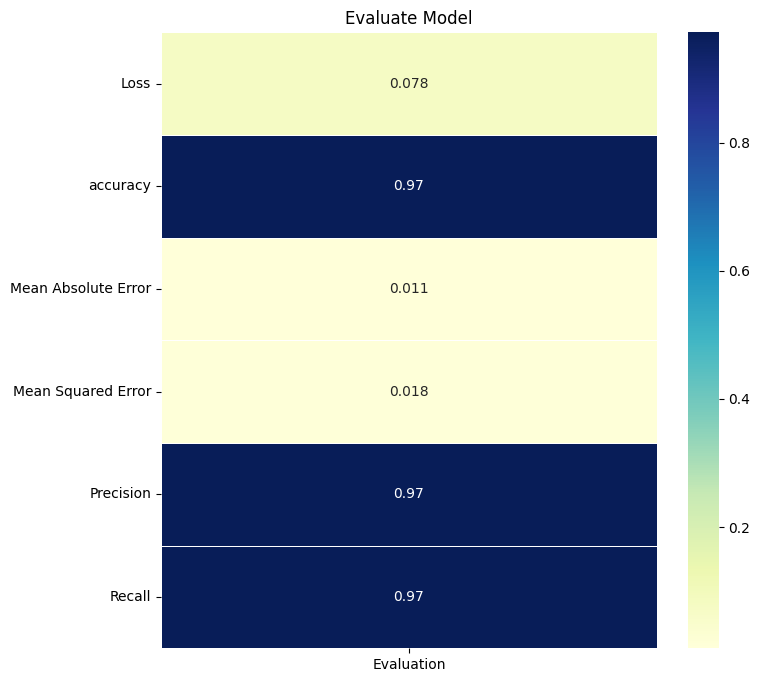

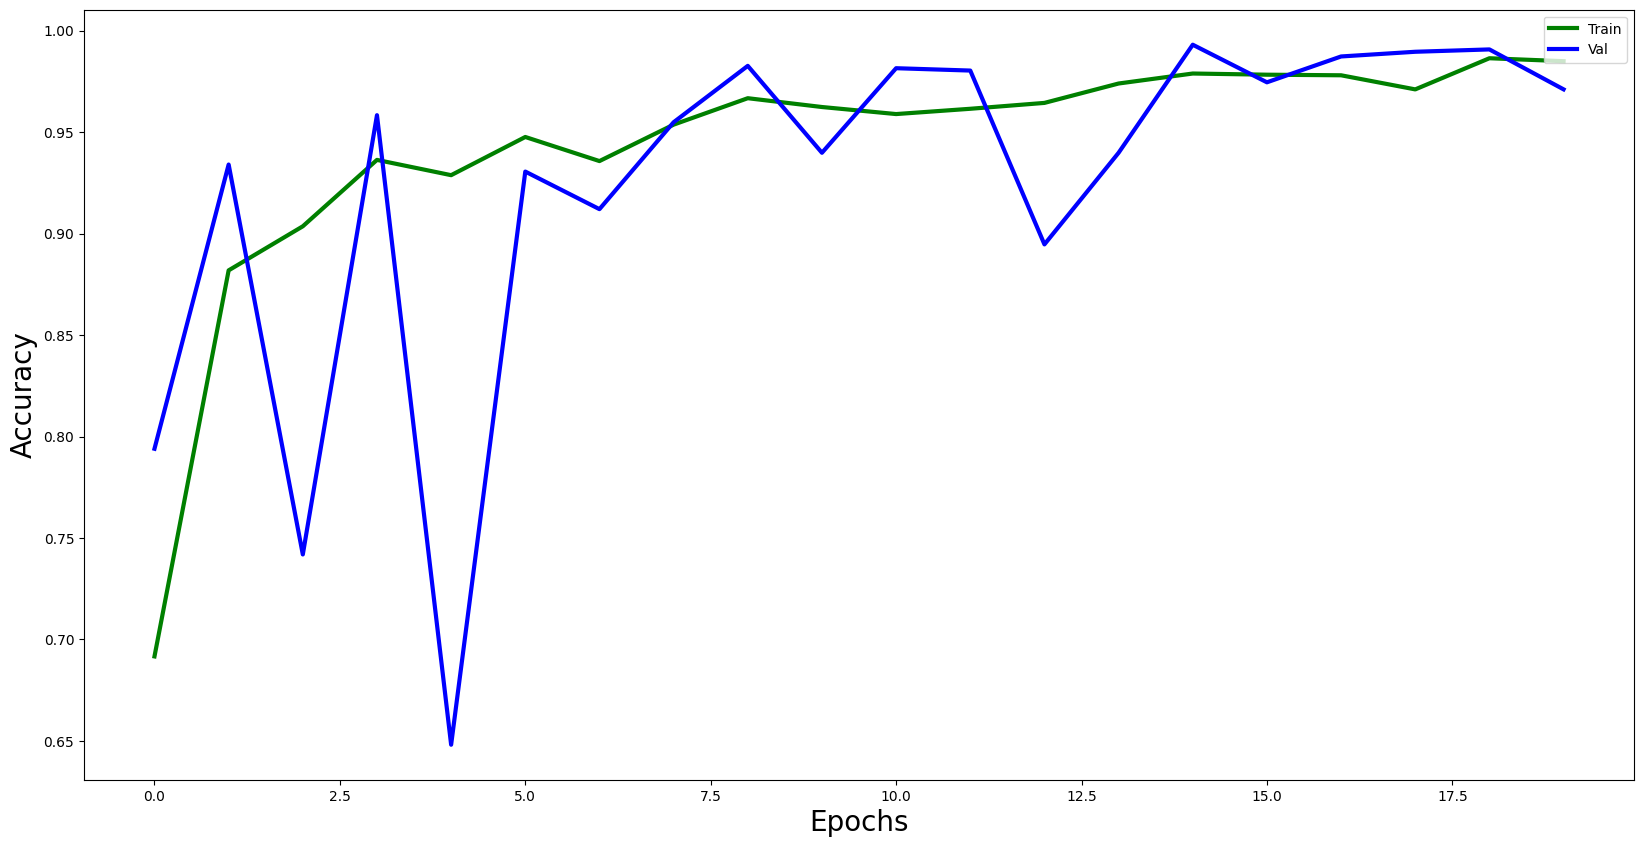

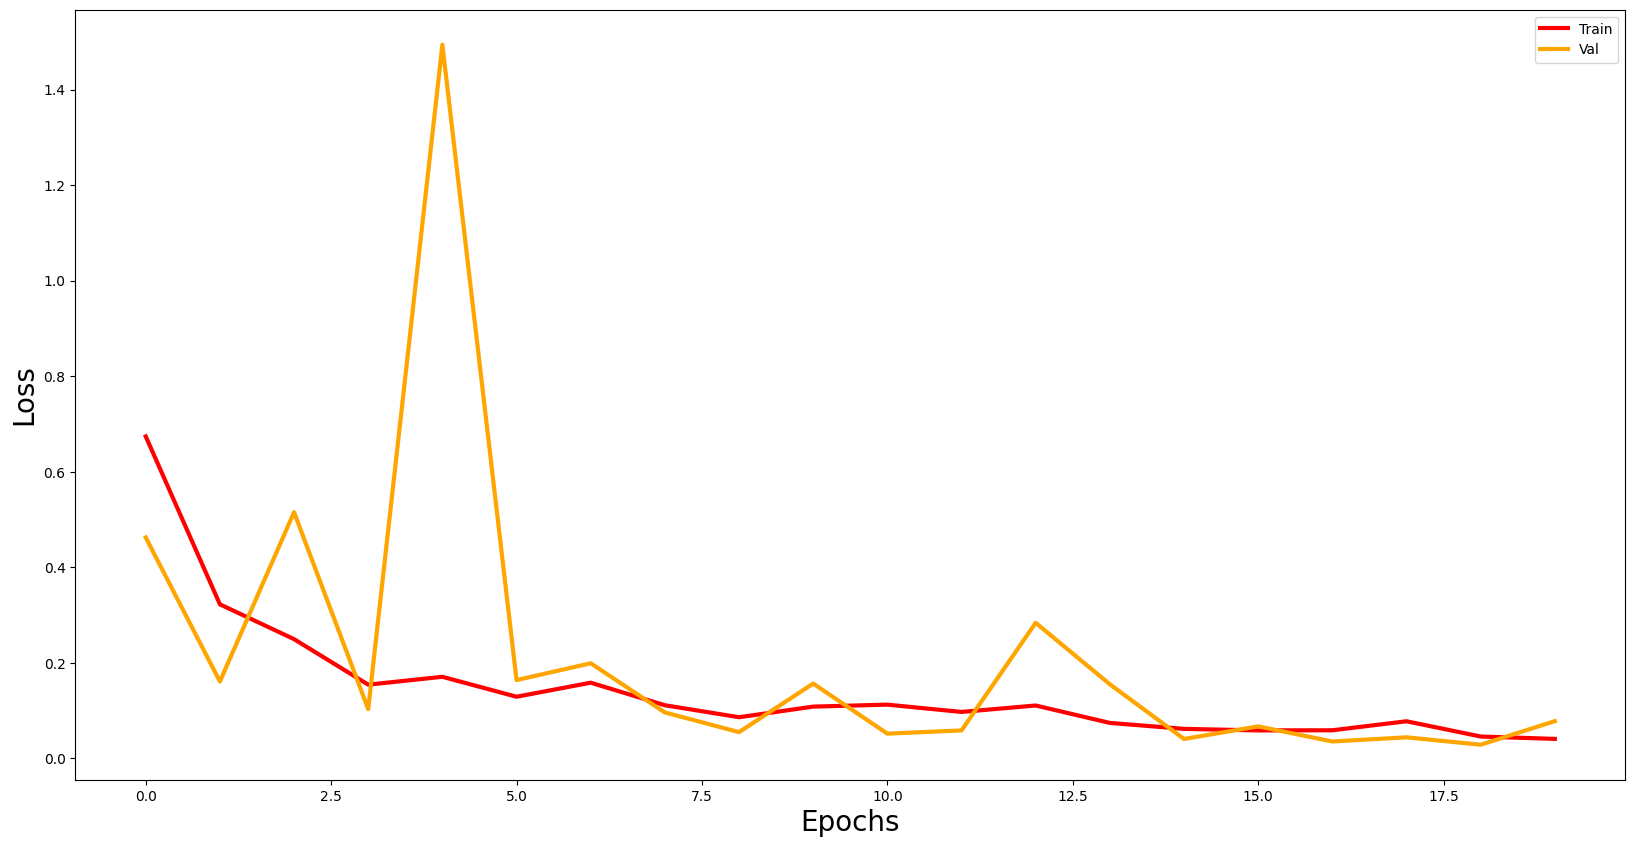

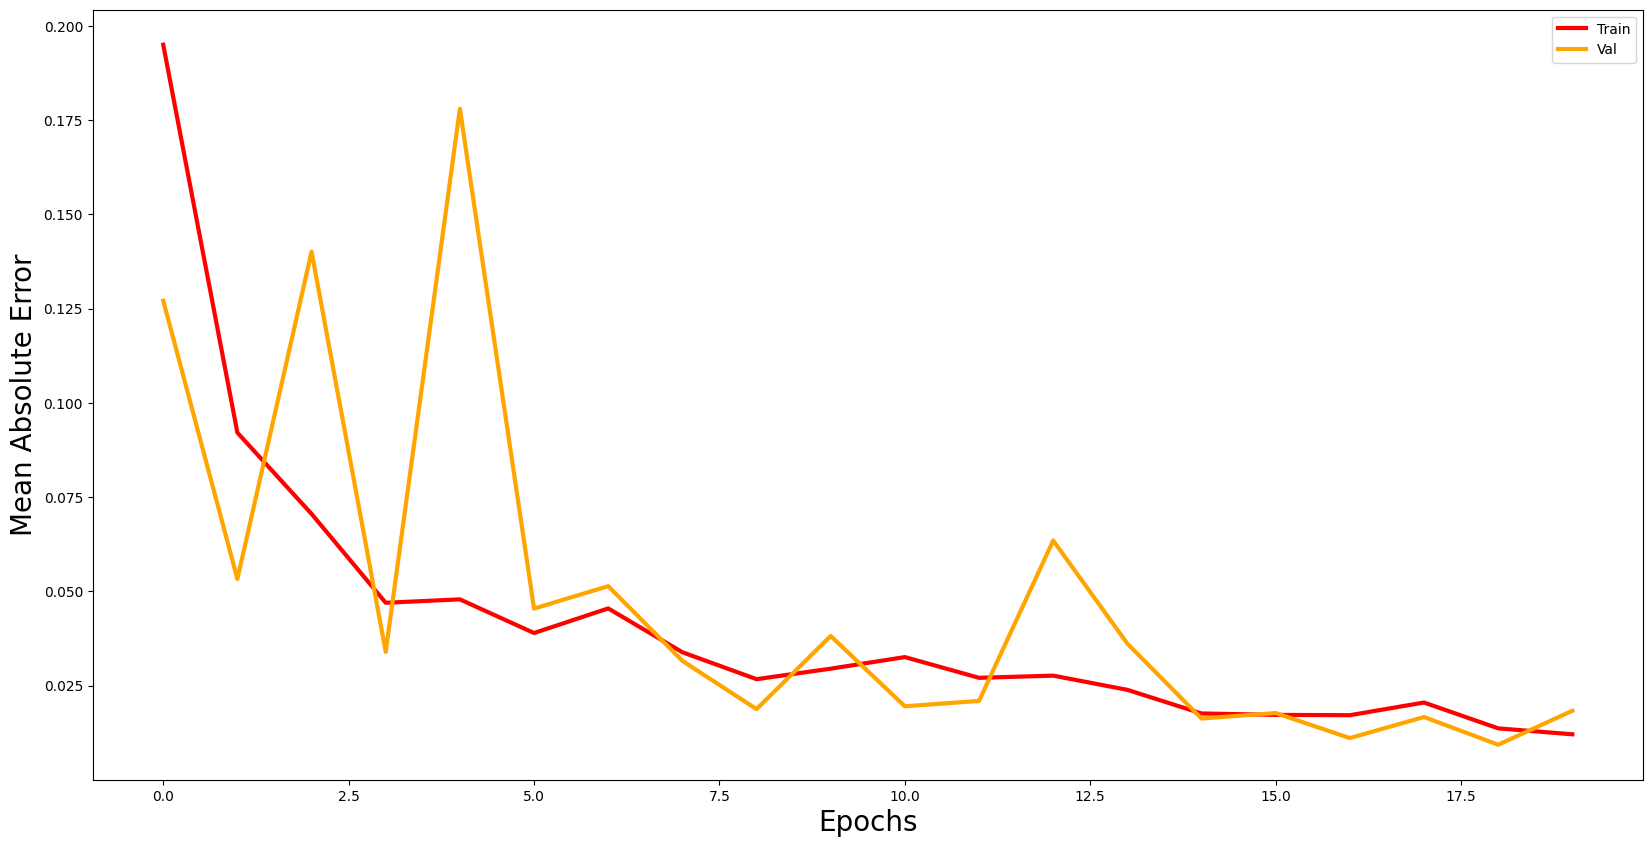

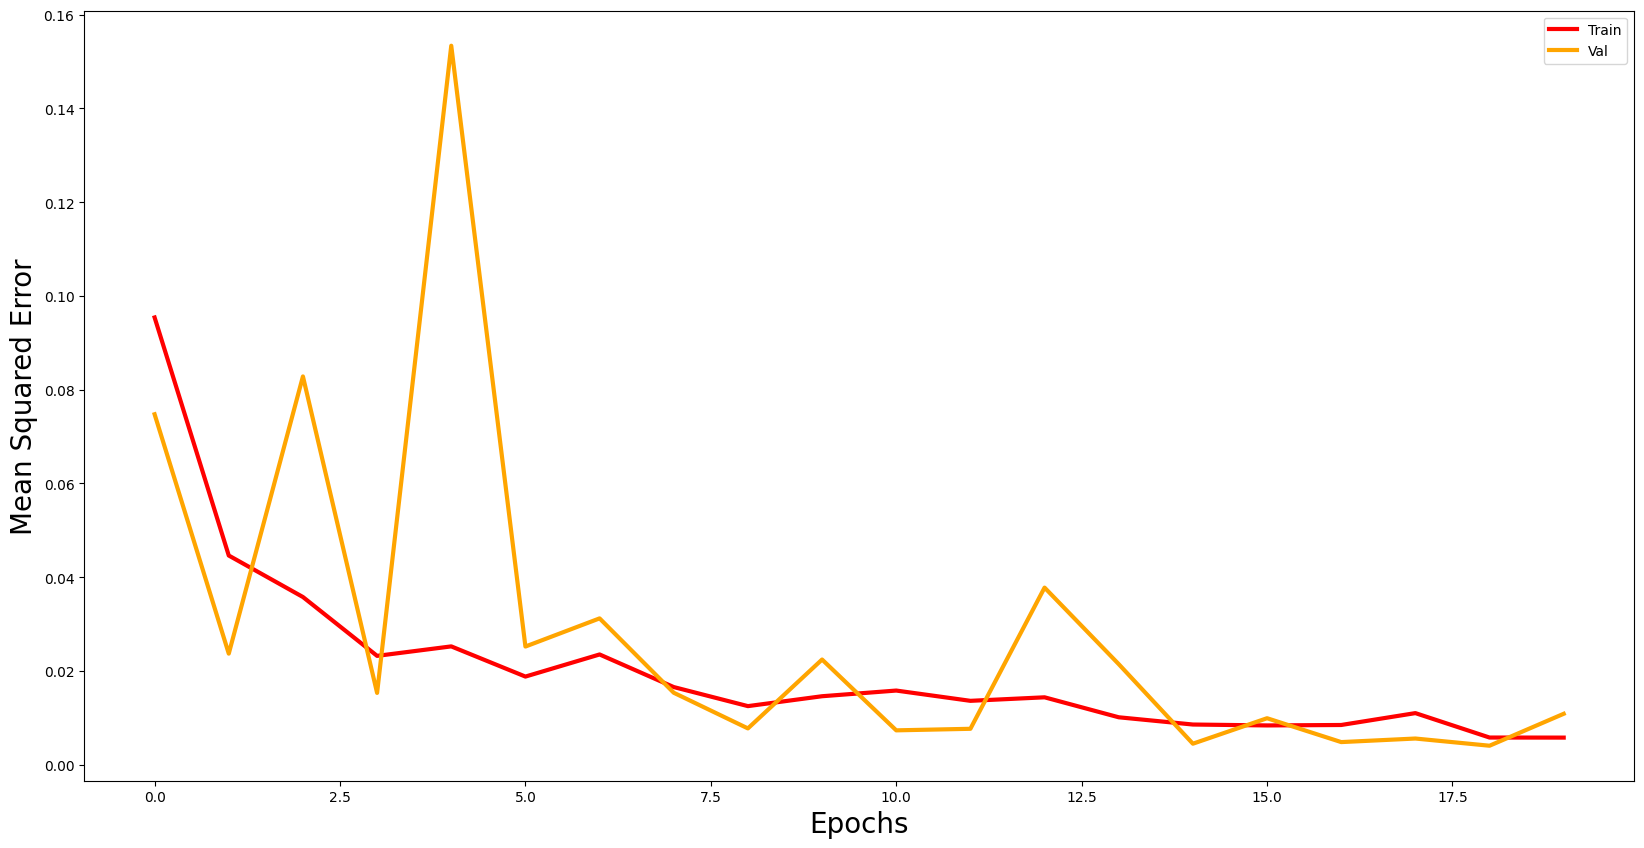

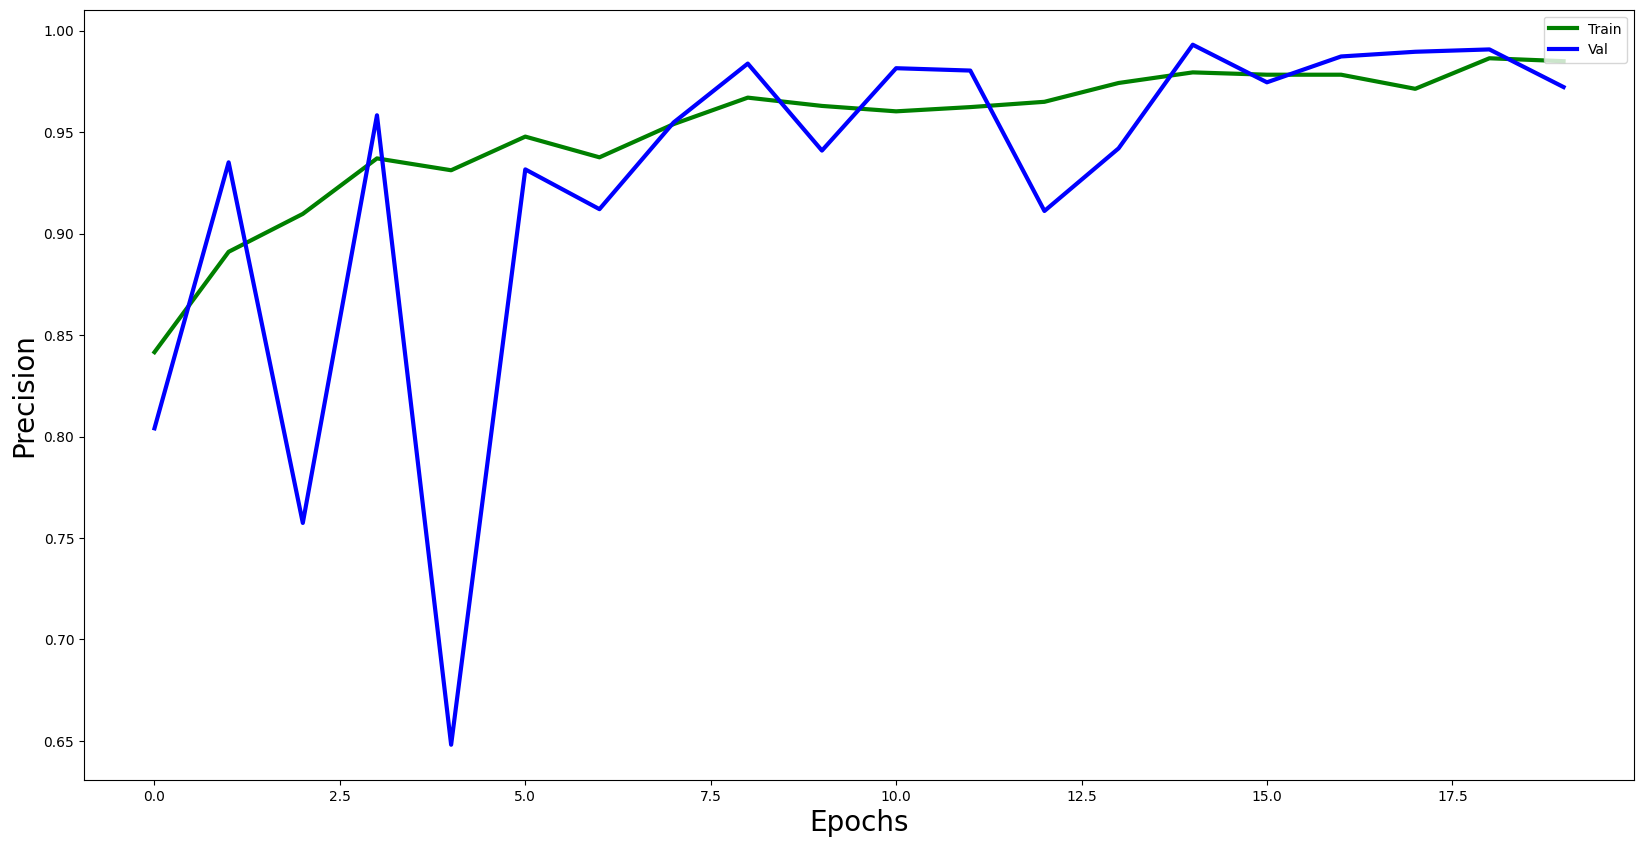

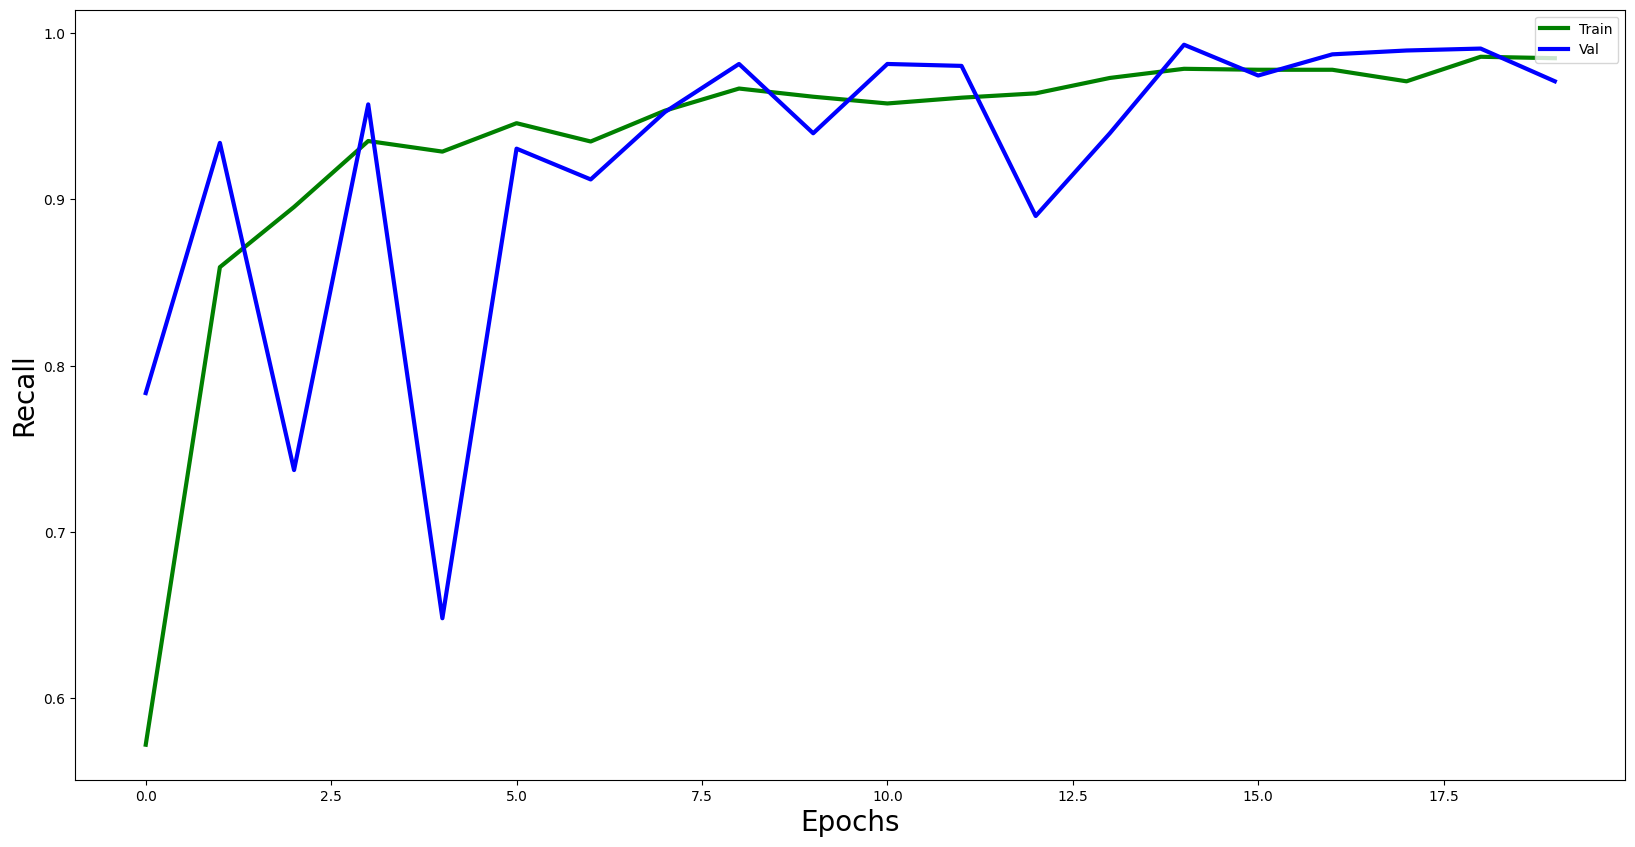

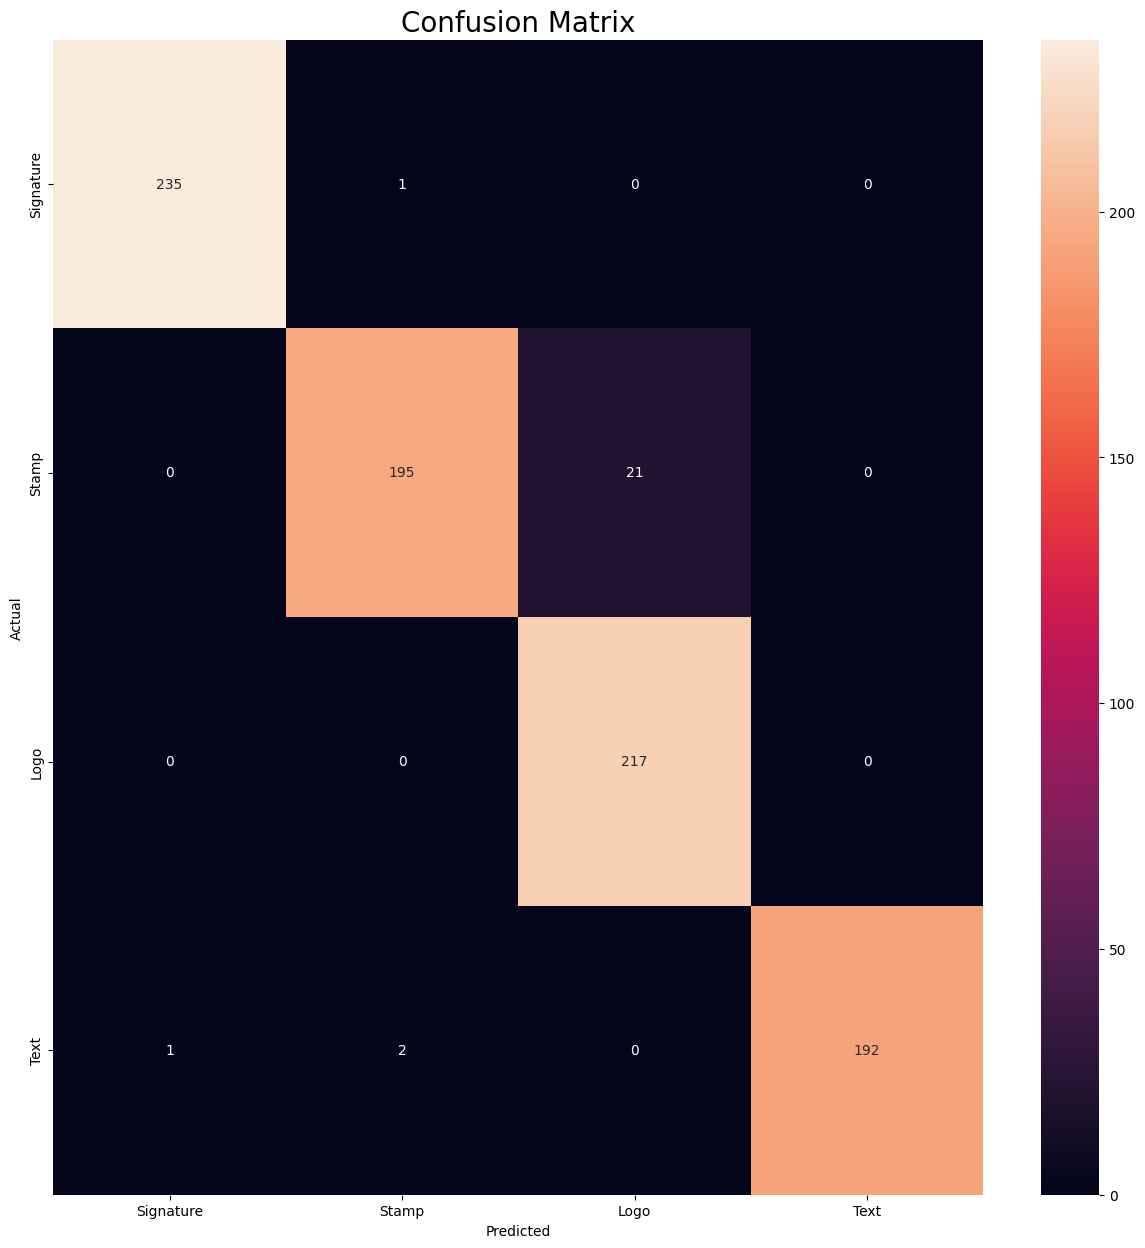

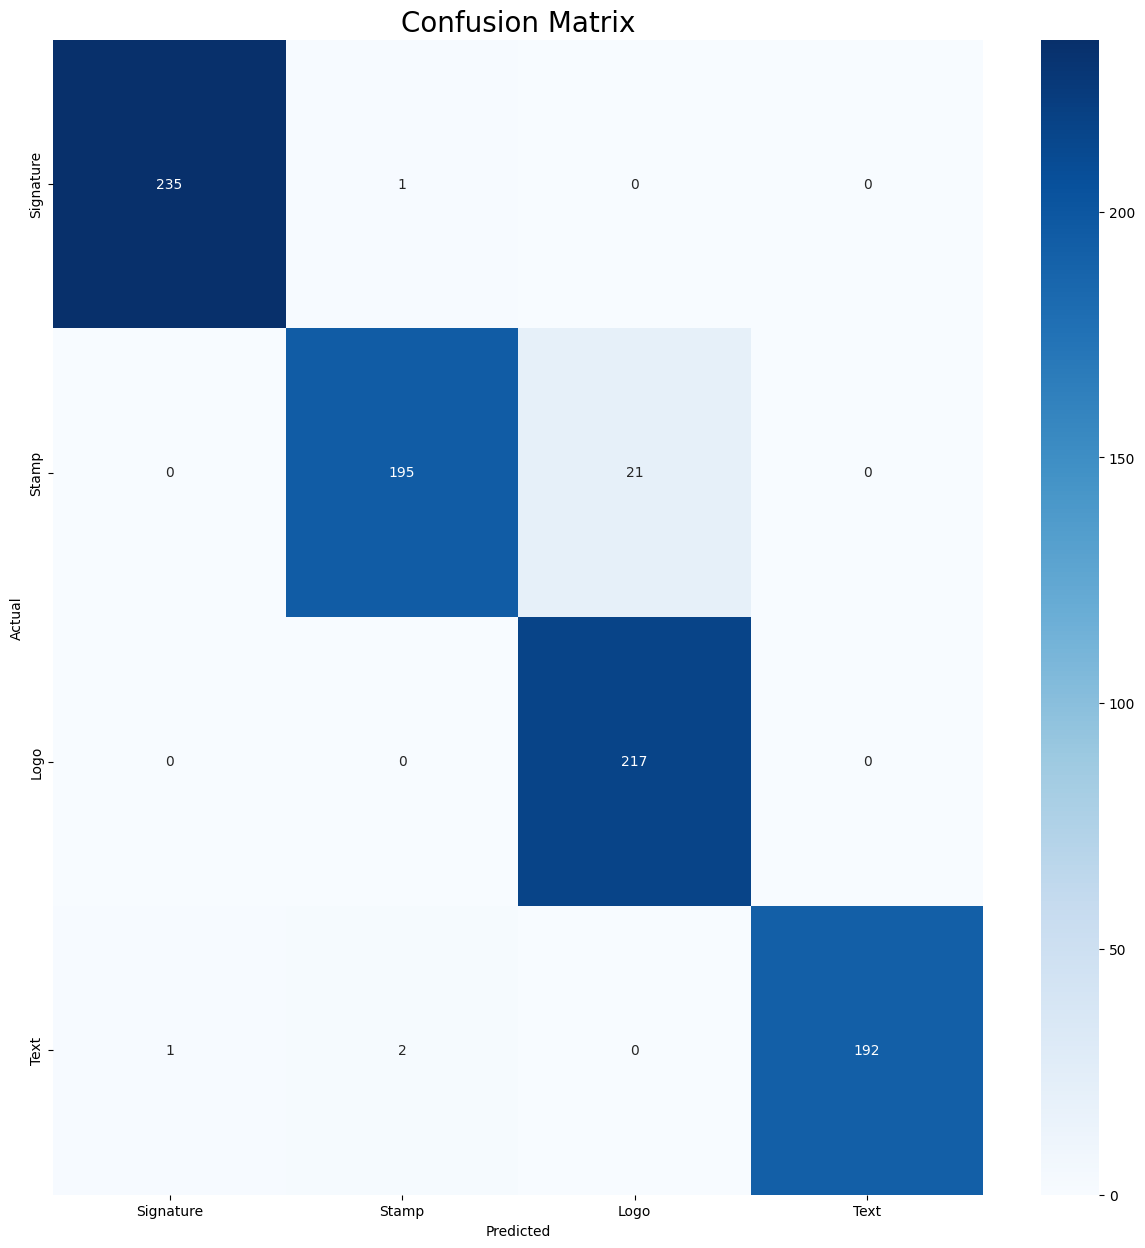

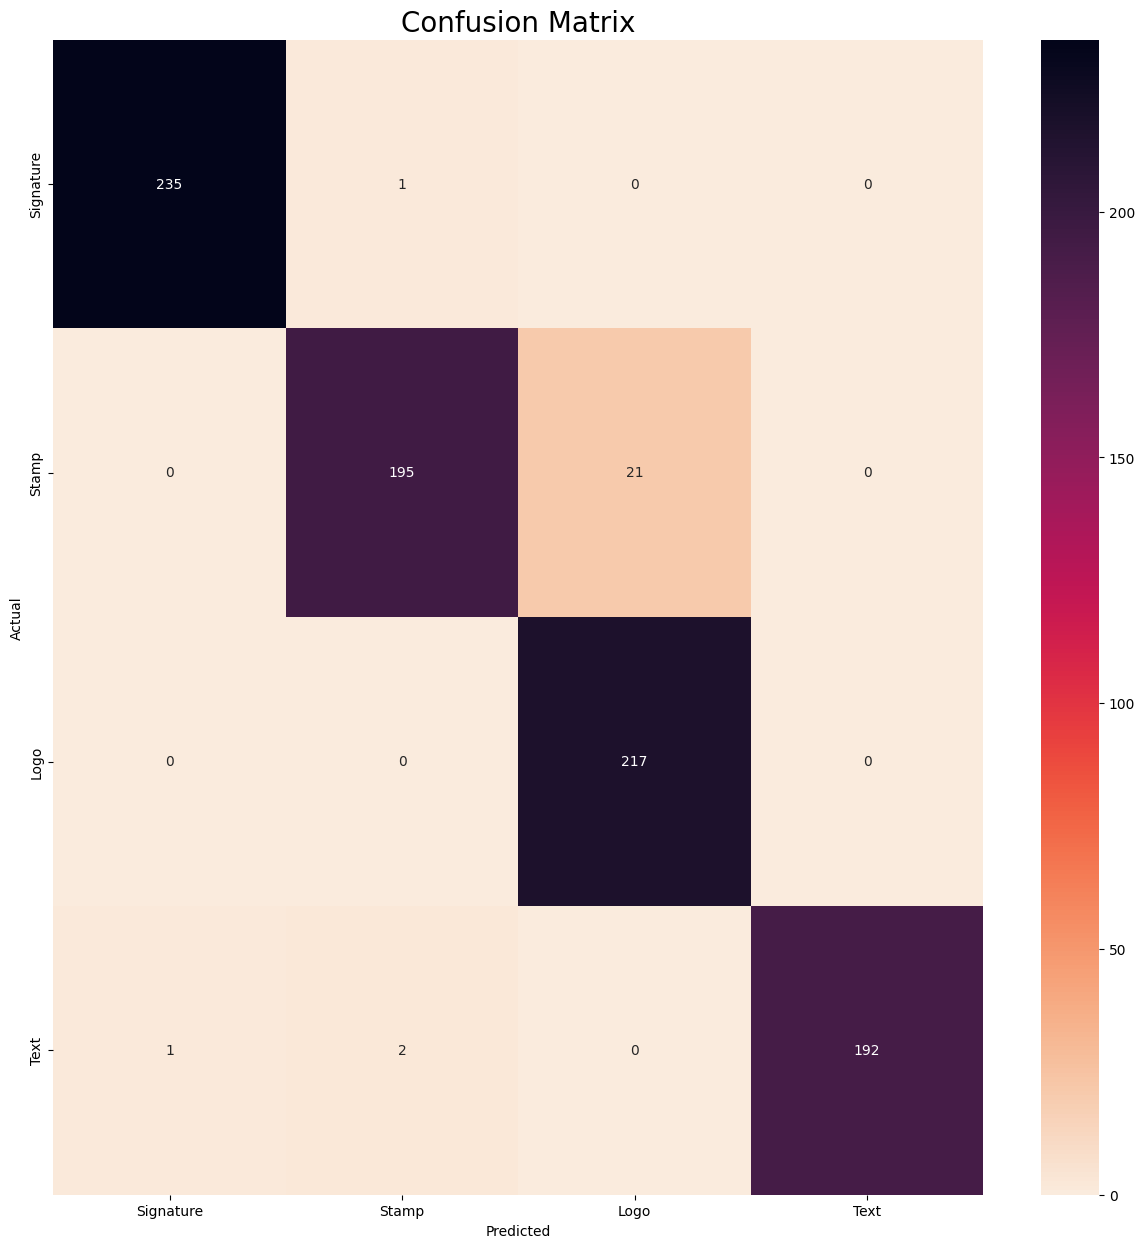

27/27 [==============================] - 0s 18ms/step


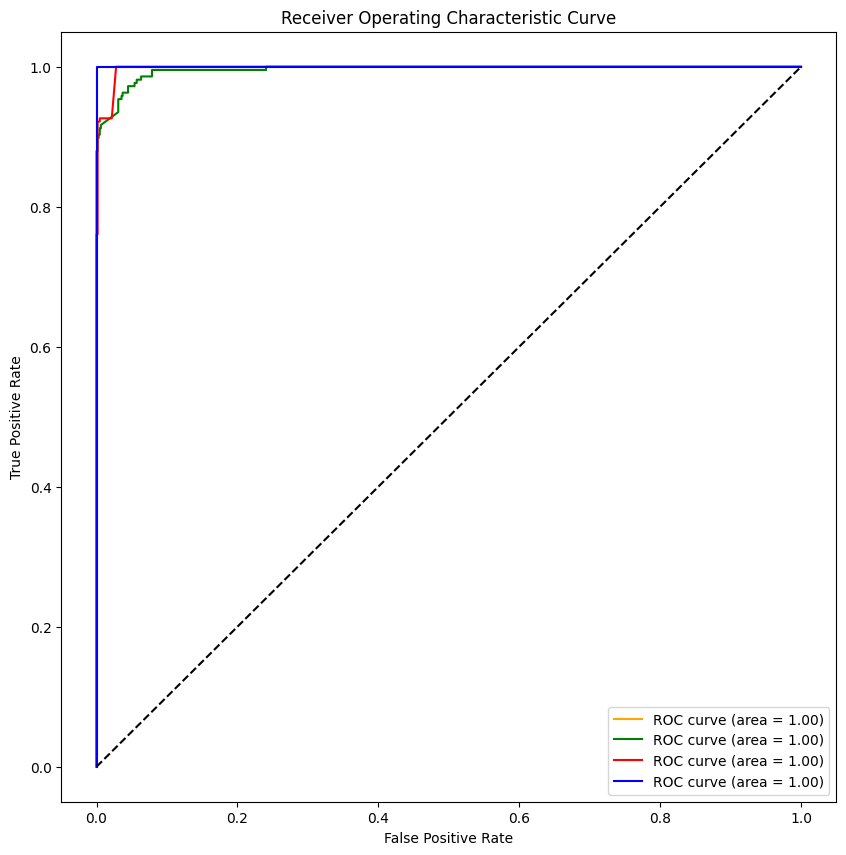

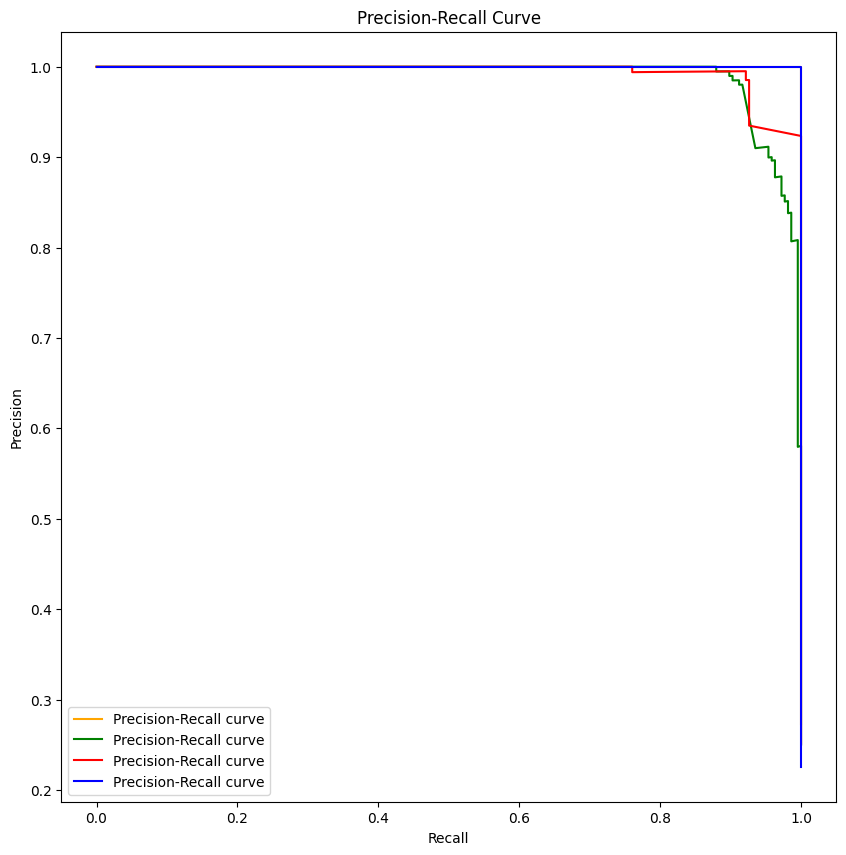

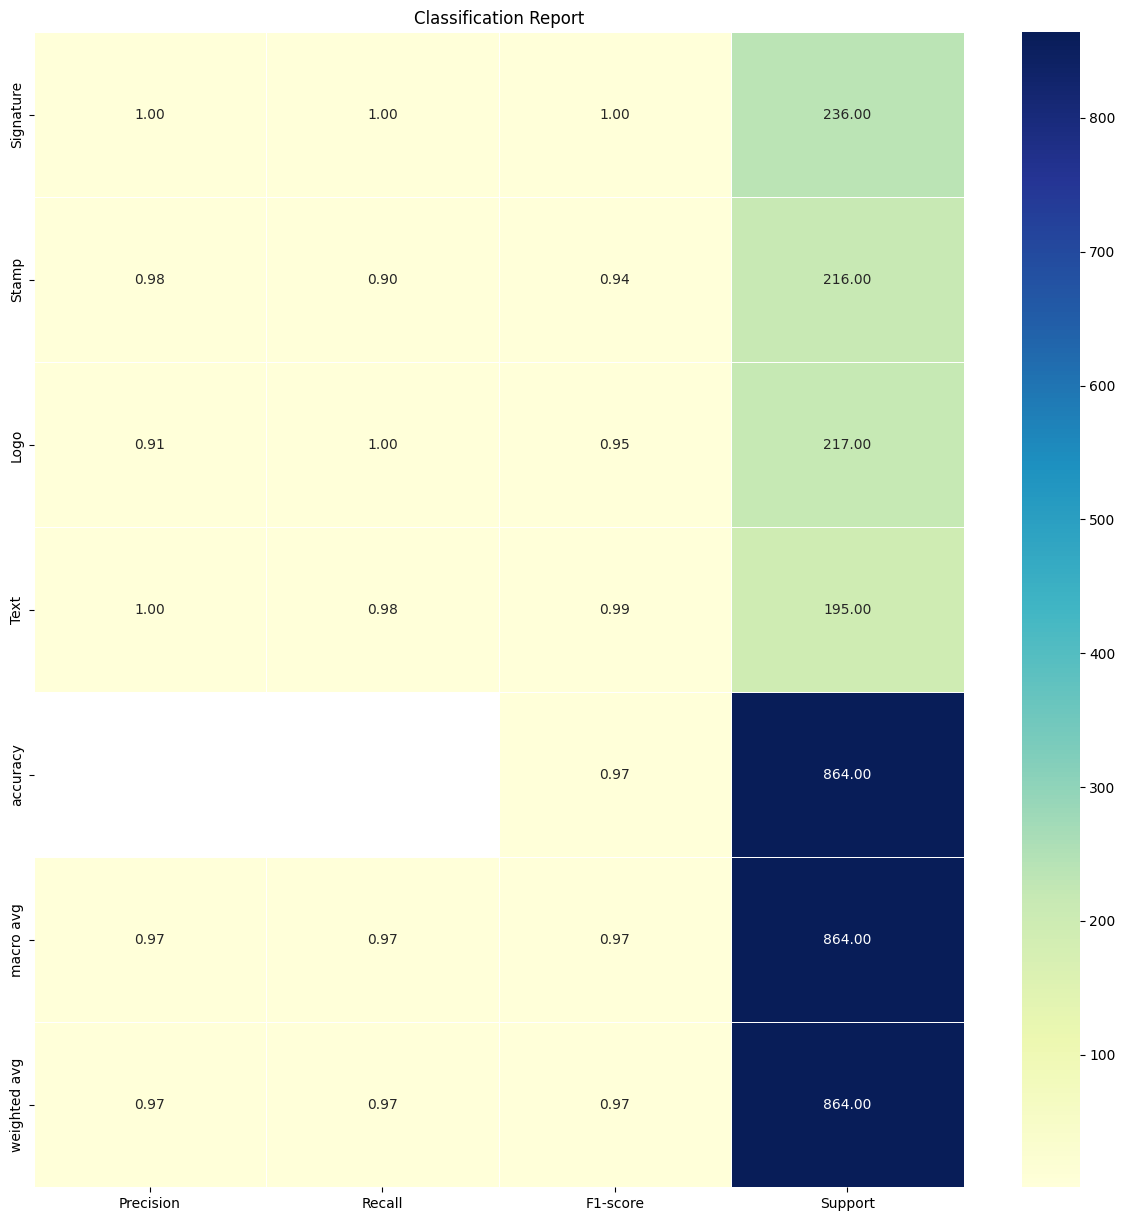

In [12]:
ploting(hist_df,model,x_test,y_test,["Signature","Stamp","Logo","Text"],"MODEL_WITHOUT_HIST")

============================================================ Evaluate Model ============================================================


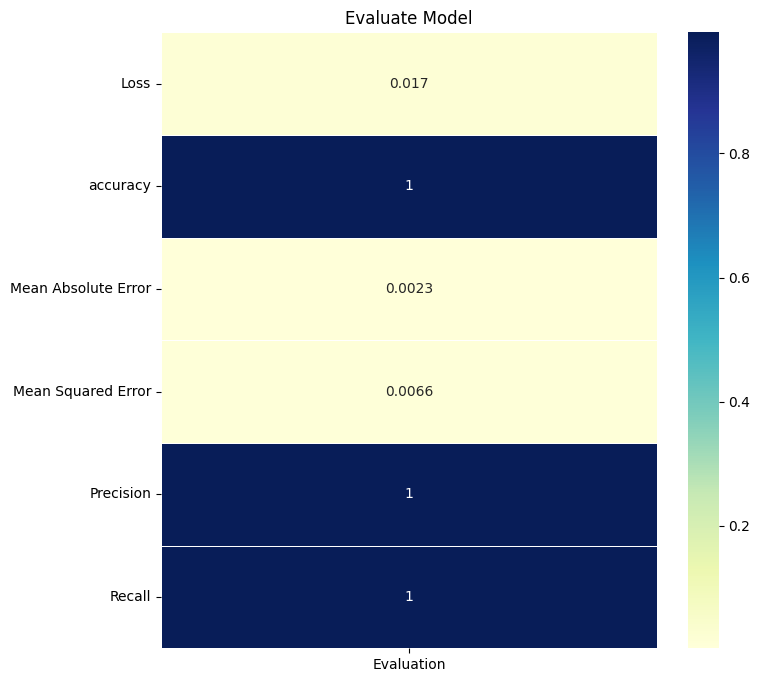

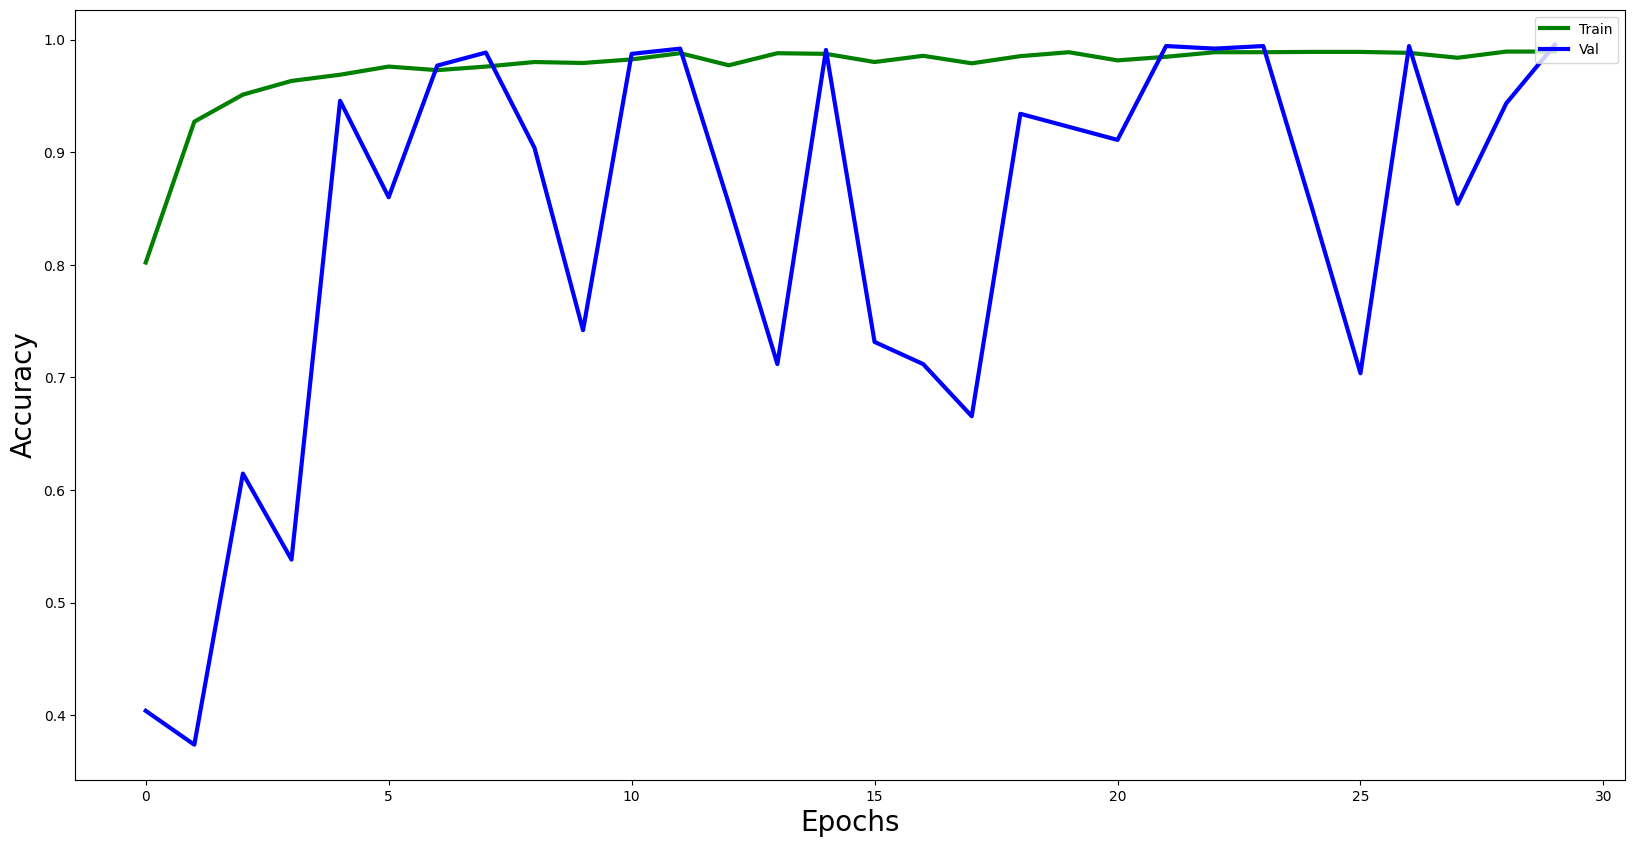

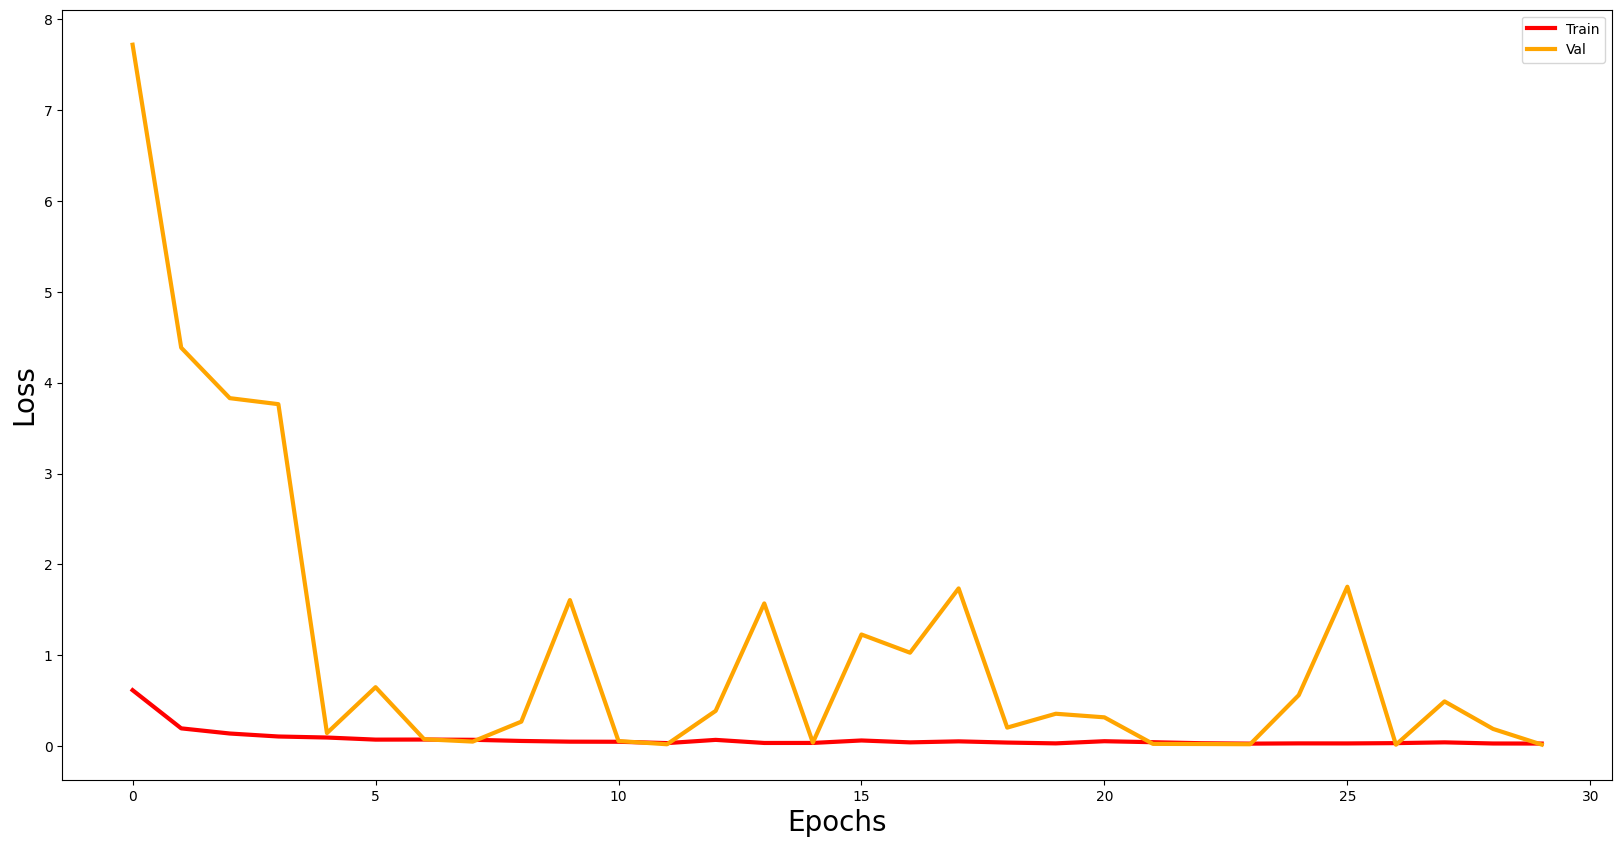

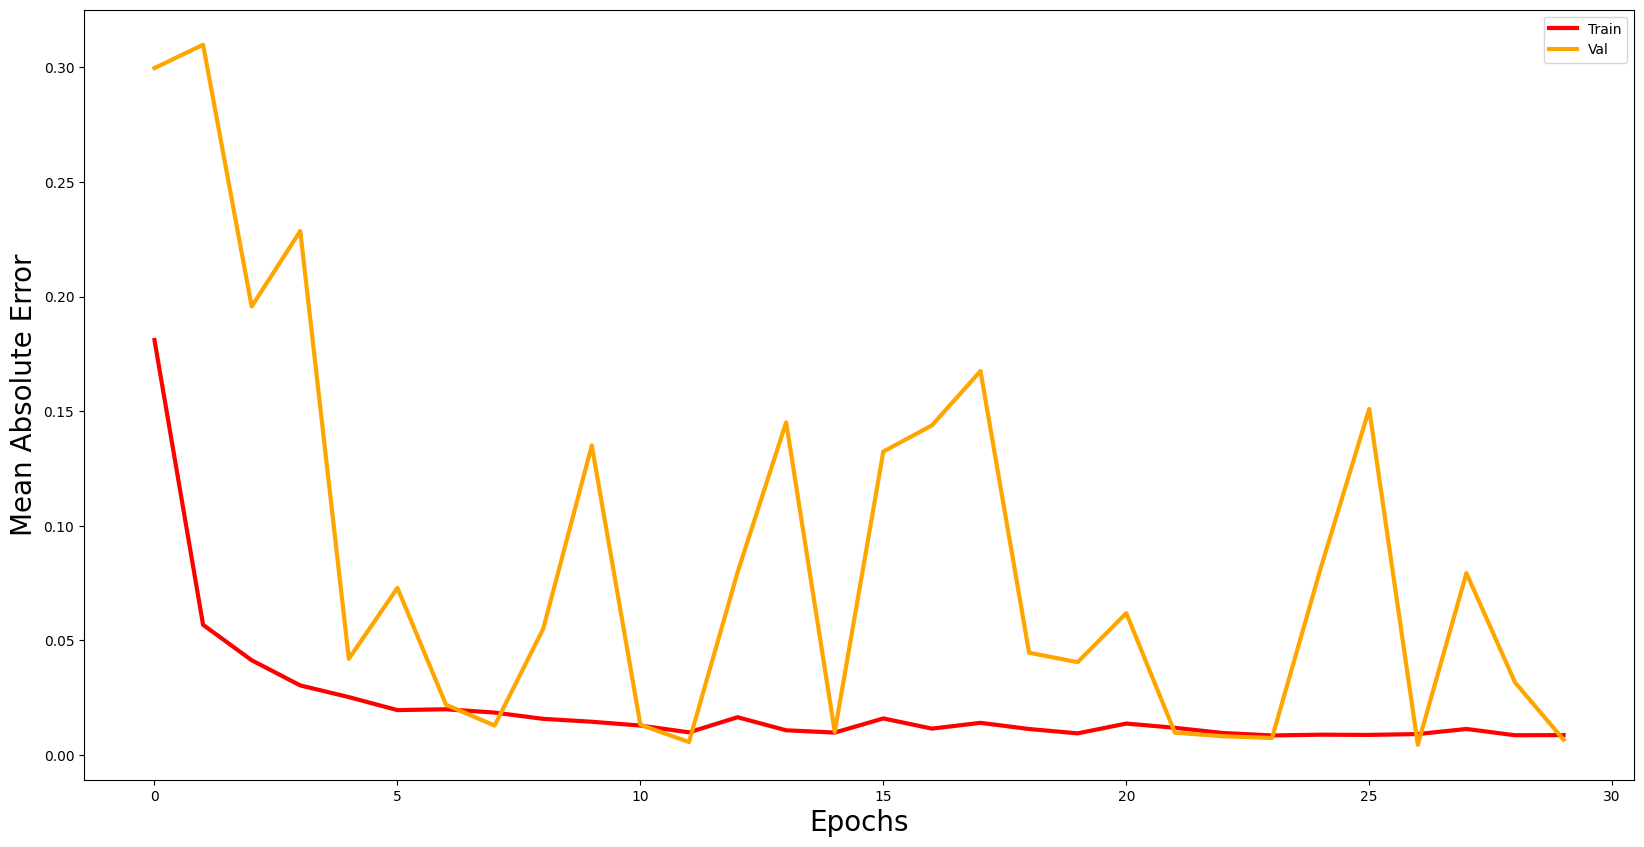

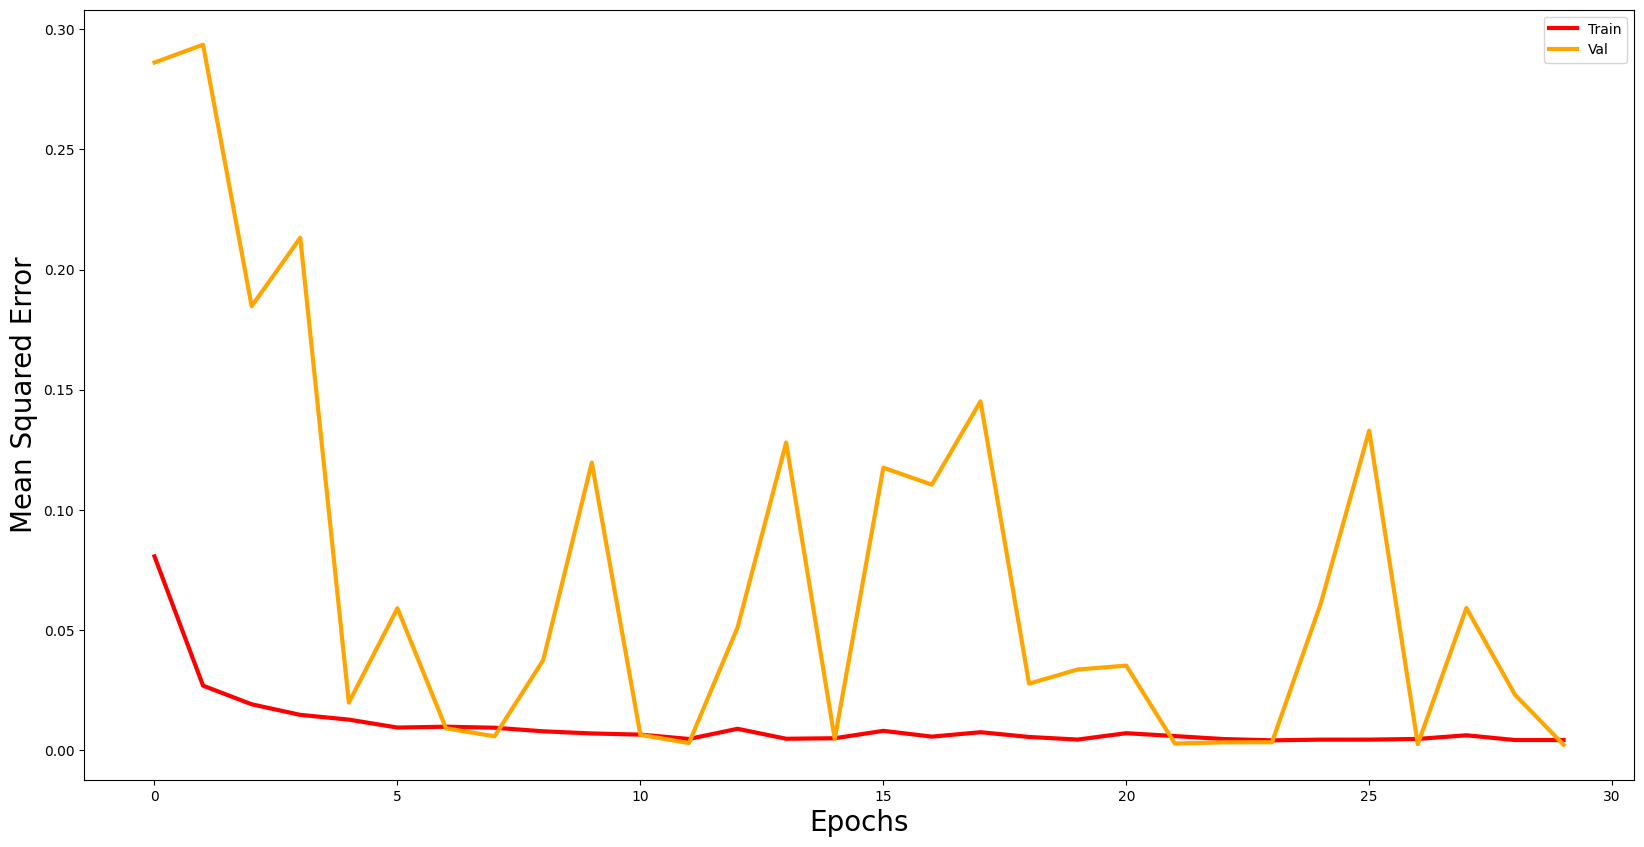

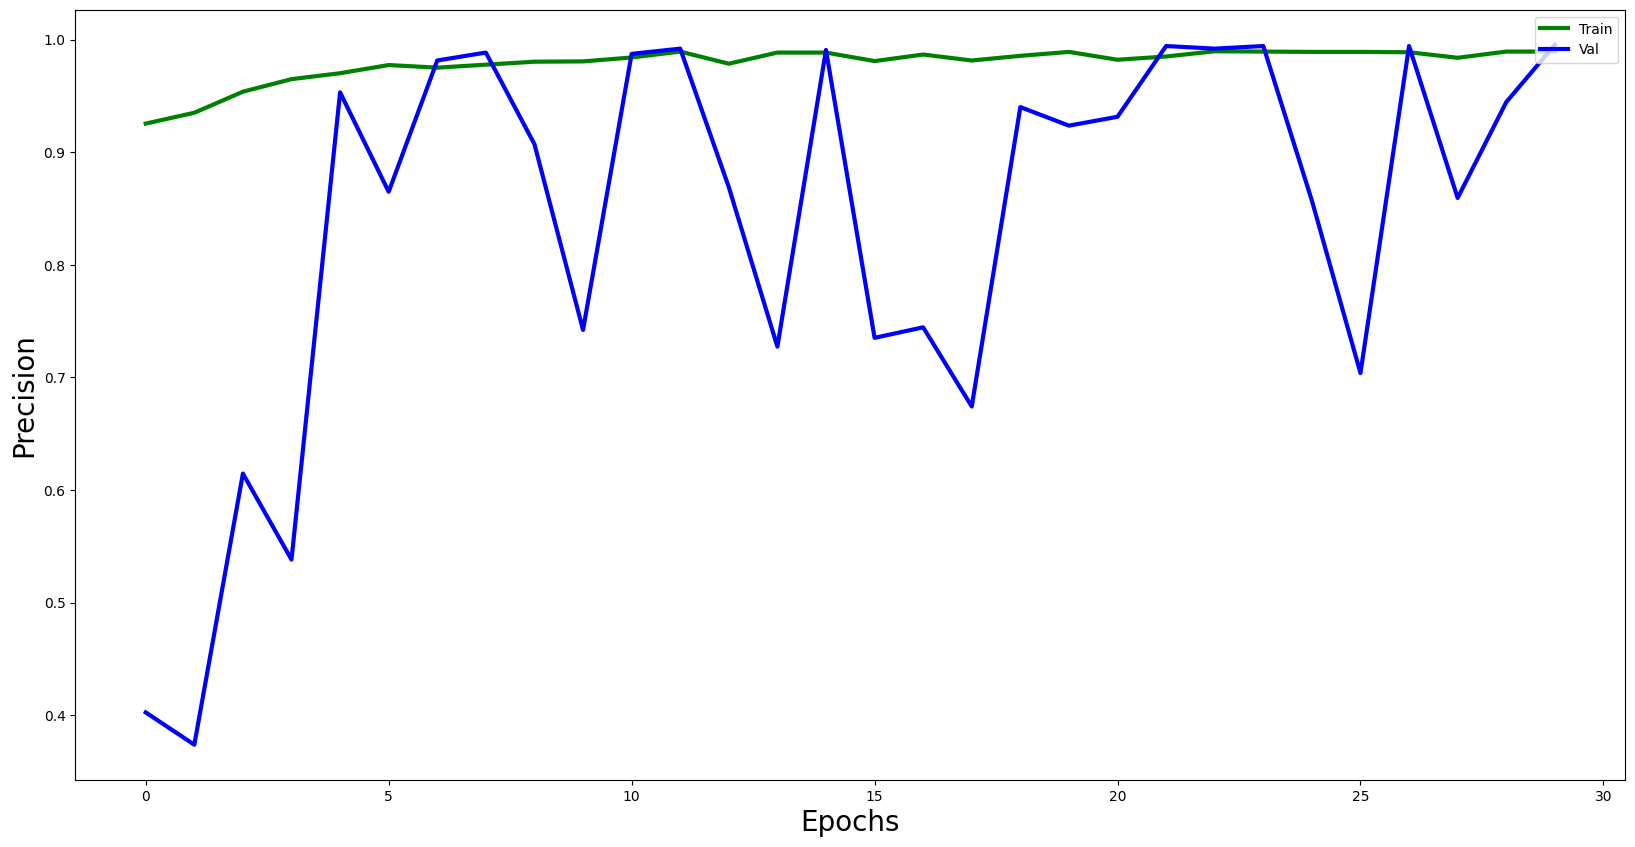

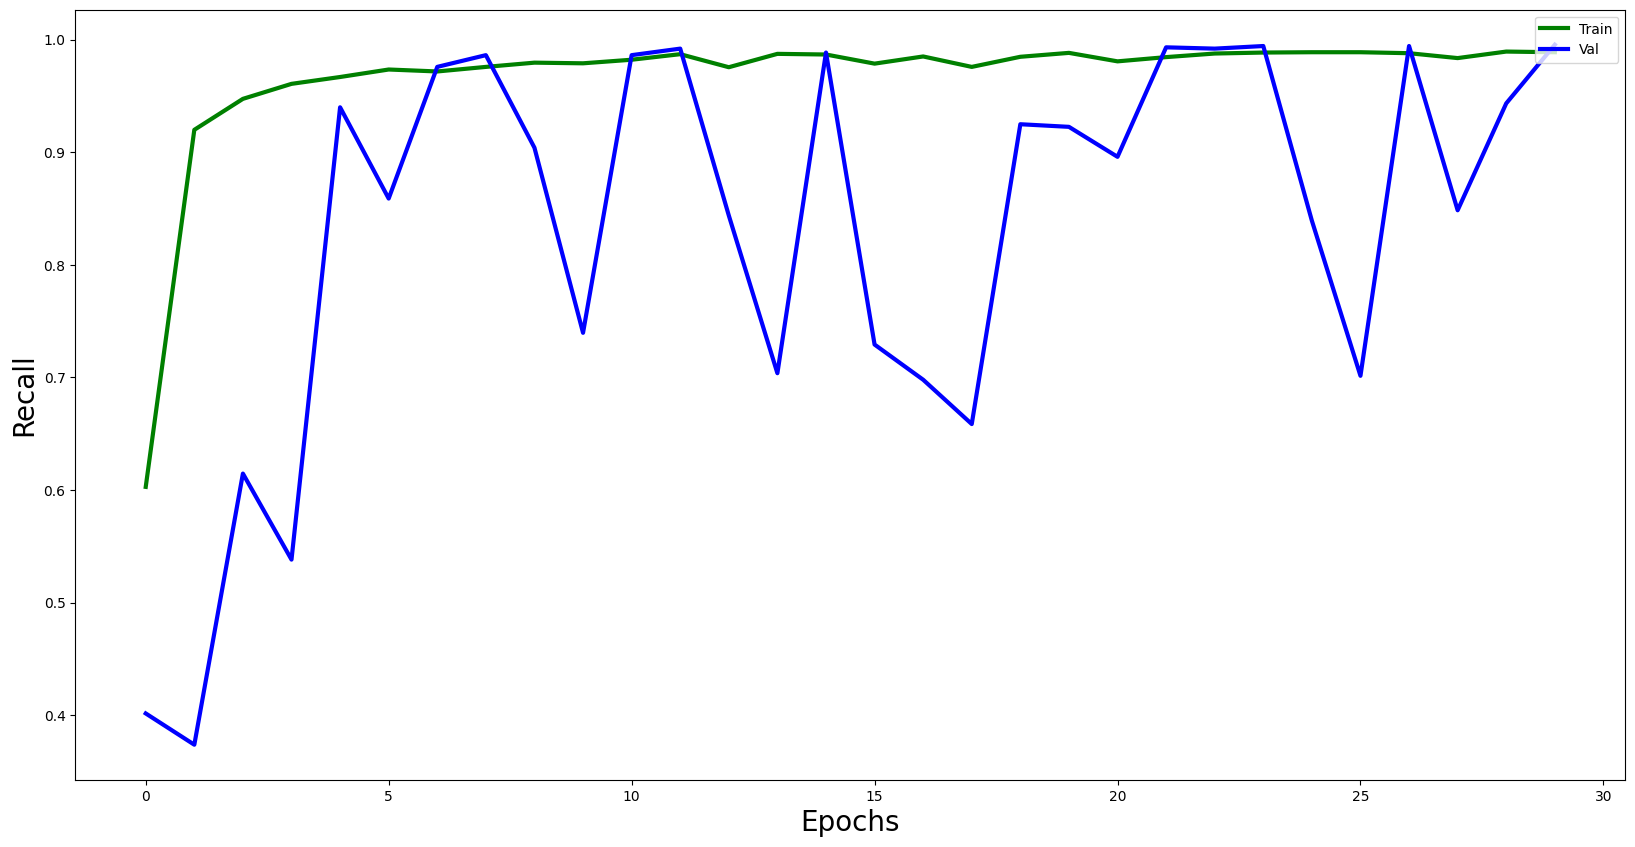

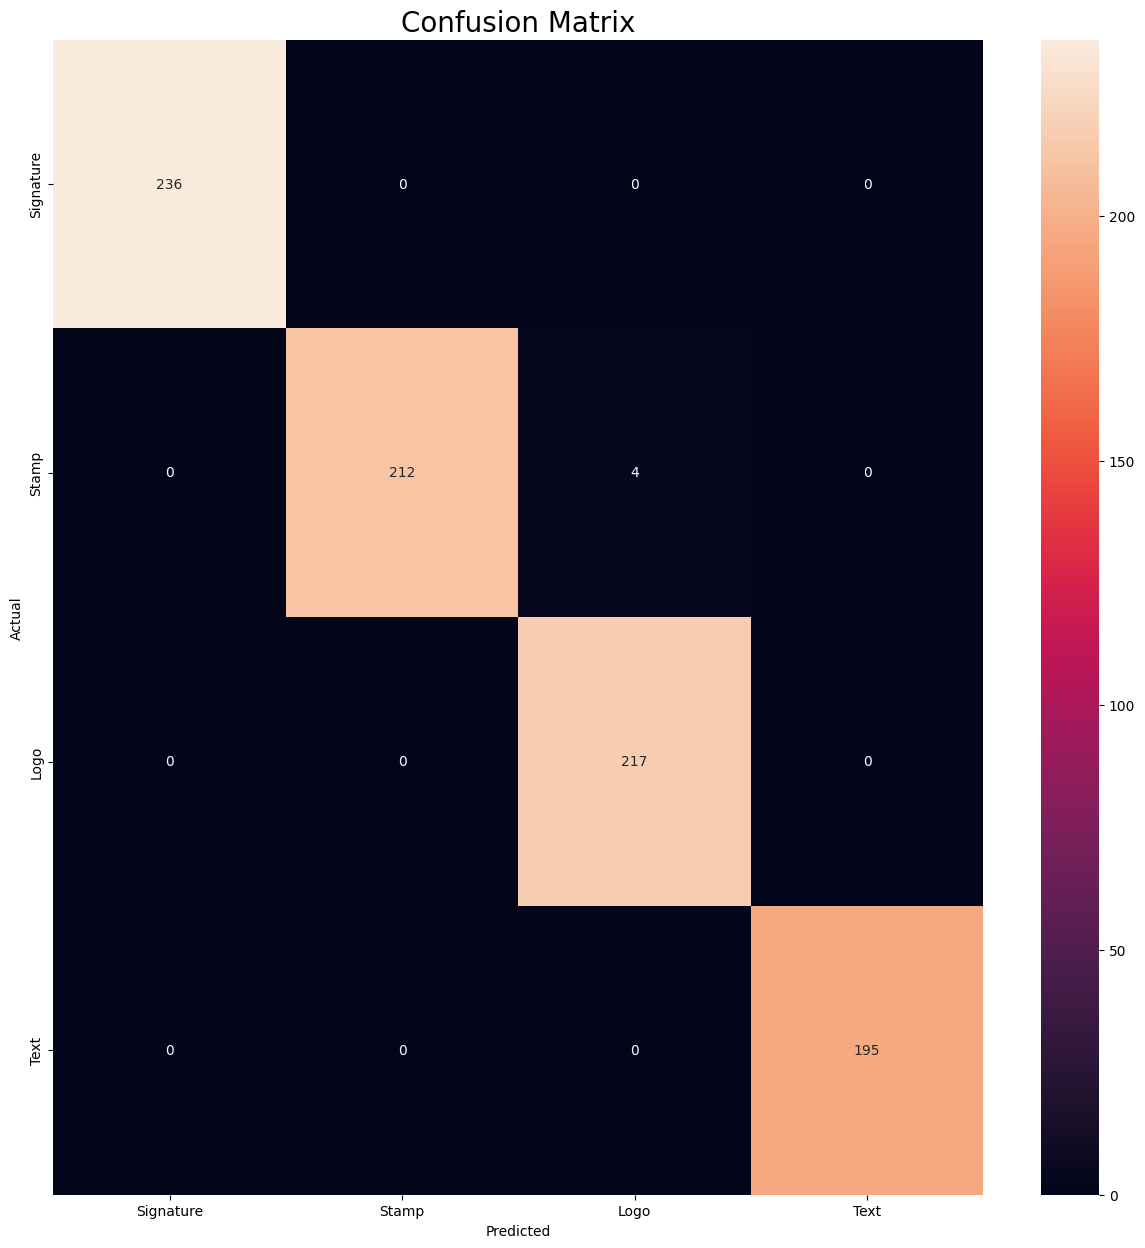

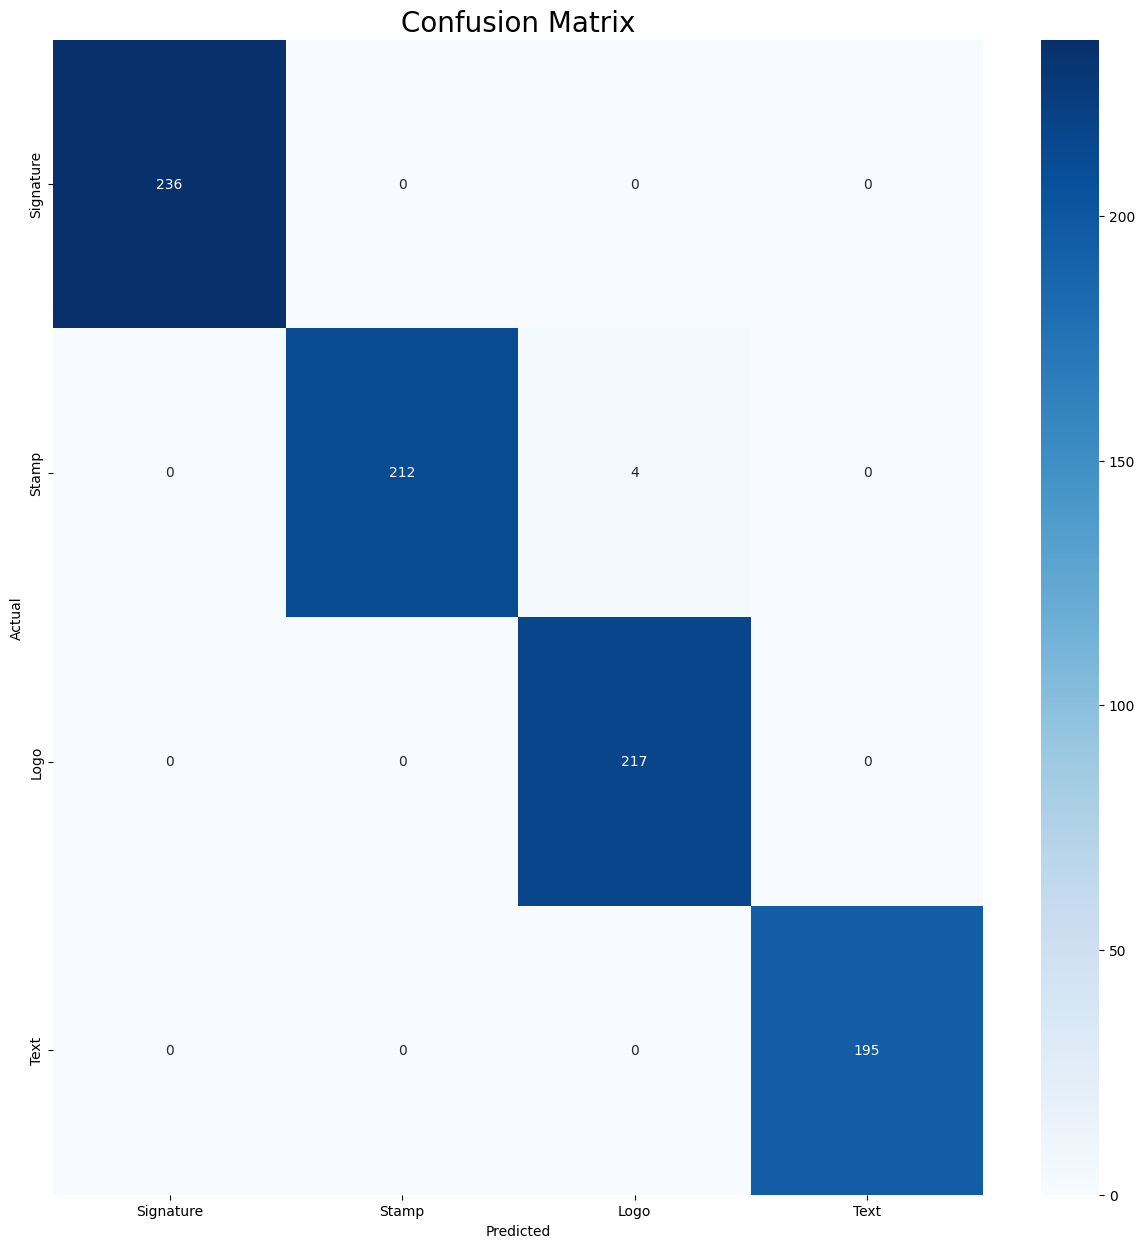

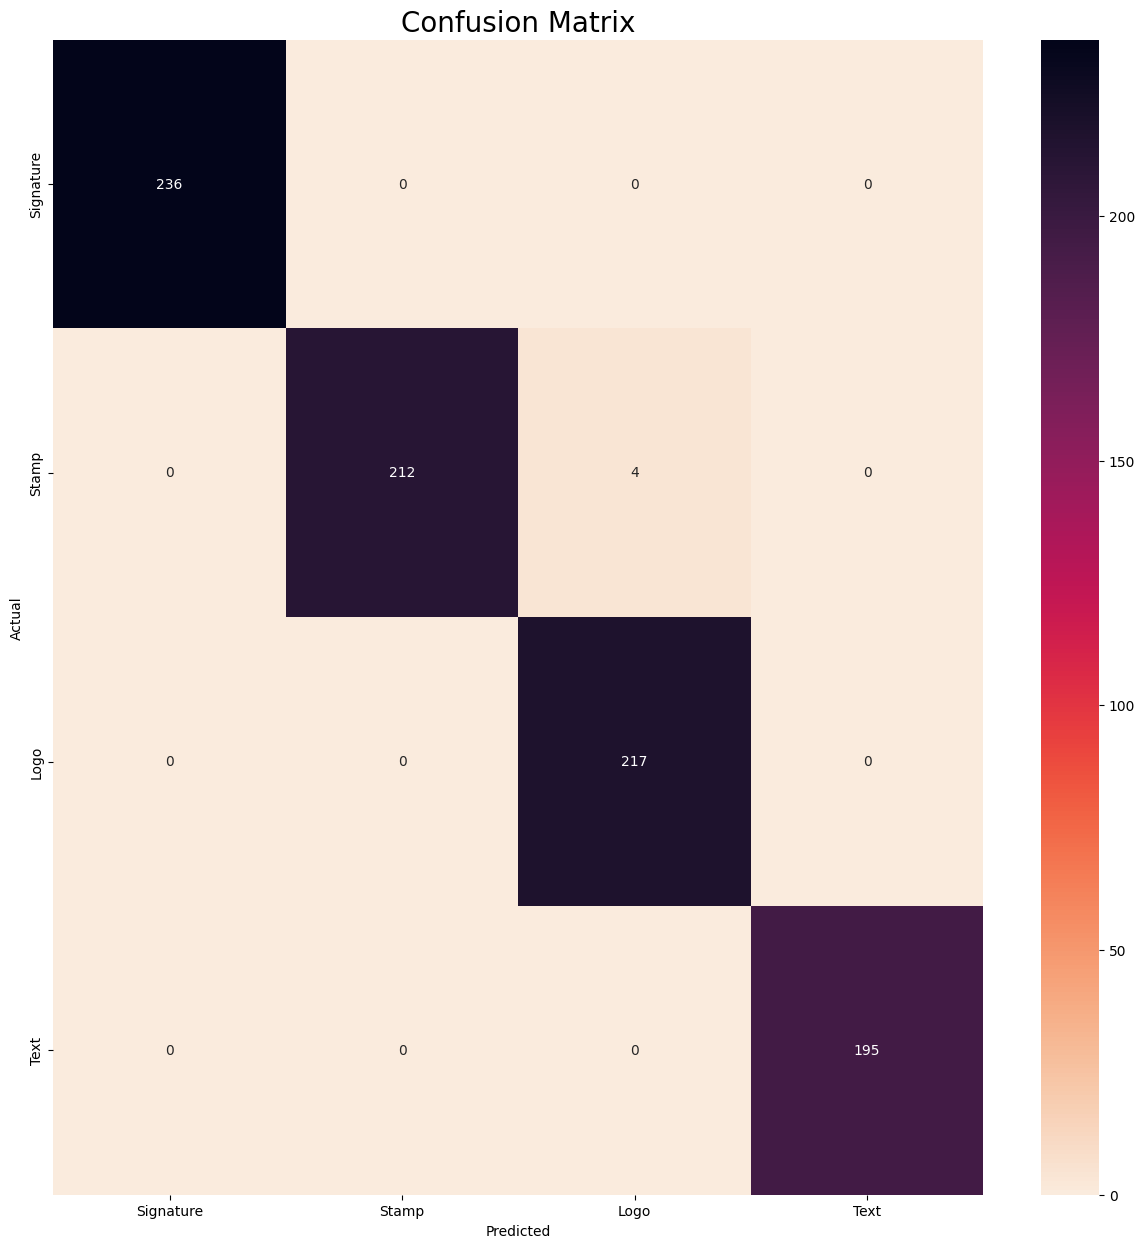

27/27 [==============================] - 0s 18ms/step


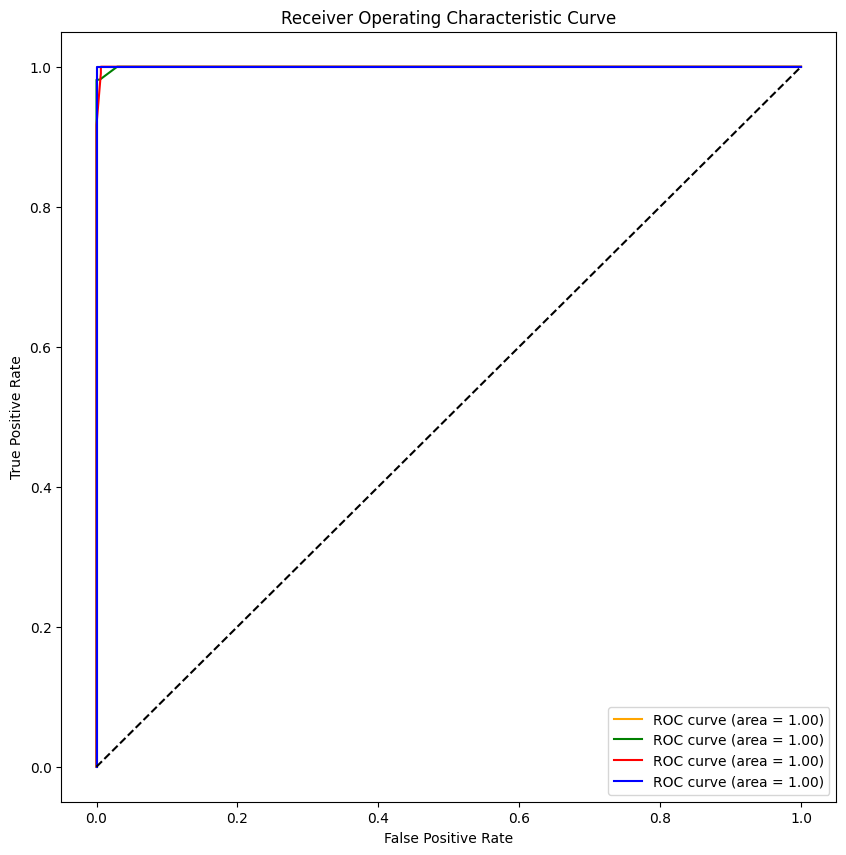

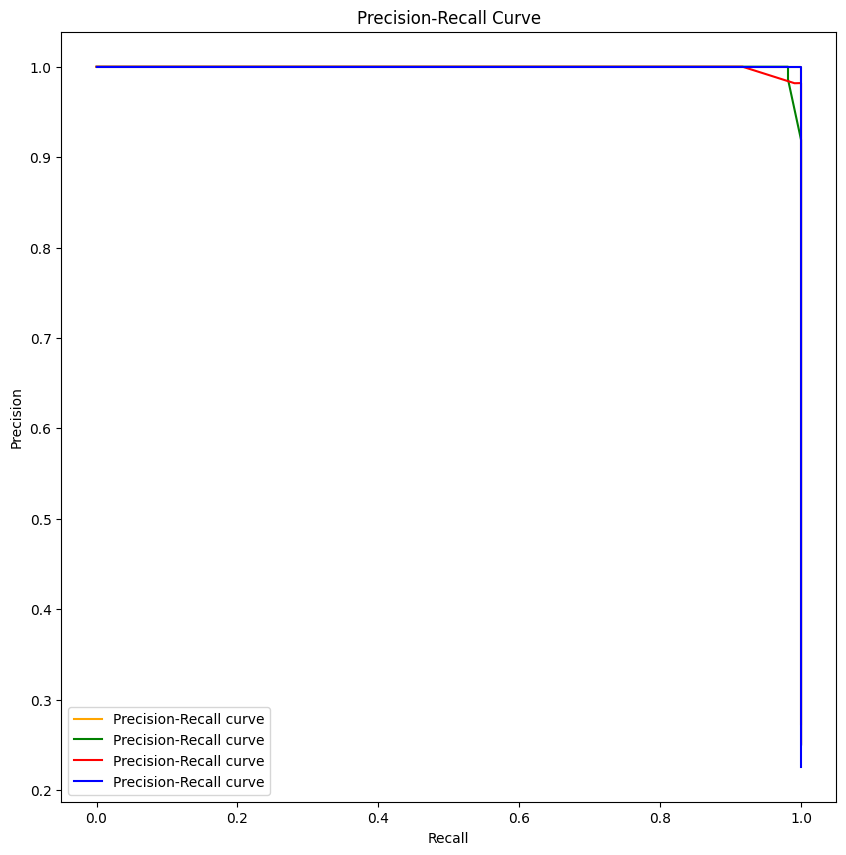

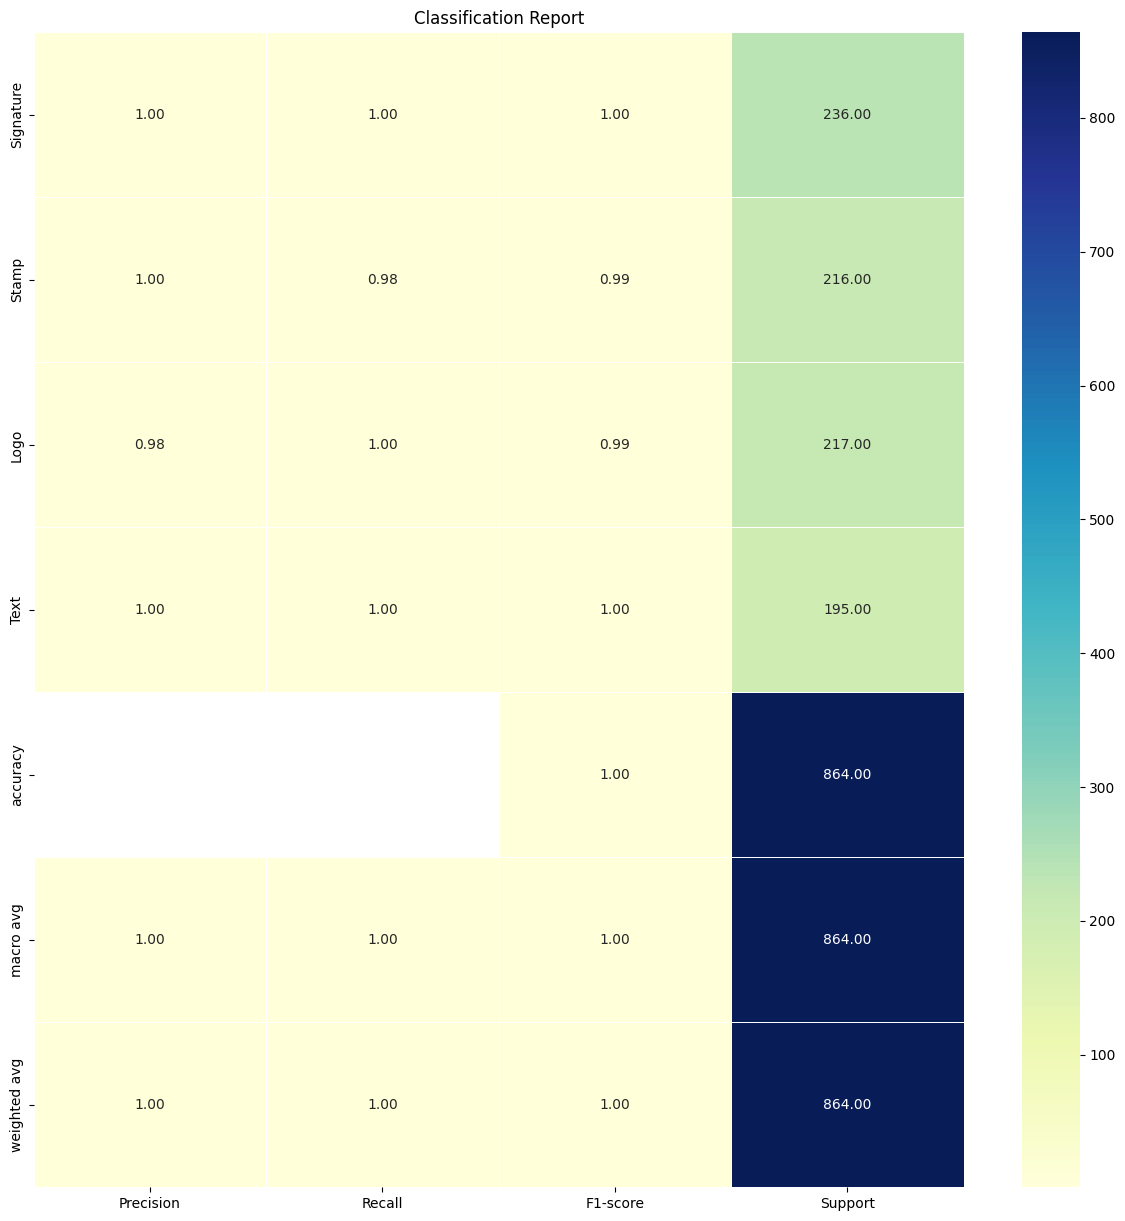

In [9]:
ploting(hist_df,model,(x_test,xh_test),y_test,["Signature","Stamp","Logo","Text"],"MODEL_WITH_HIST")

In [14]:
from keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
model = load_model("/home/abdullah/python/Signature Detection/DATA 1 WITH HIST/MODEL_WITH_HIST_model.keras")

In [175]:
def divide_image_into_parts(image, window_size=(224, 224),threshold=0.5):
  # check if image size is divisible by window size if not then pad the image
  if image.shape[0] % window_size[0] != 0:
    image = np.concatenate((image, np.ones((window_size[0] - image.shape[0] % window_size[0], image.shape[1], image.shape[2]))), axis=0)
  if image.shape[1] % window_size[1] != 0:
    image = np.concatenate((image, np.ones((image.shape[0], window_size[1] - image.shape[1] % window_size[1], image.shape[2]))), axis=1)
    
  # divide image into parts and predict each part and draw a rectangle on the image
  for i in tqdm(range(0, image.shape[0], window_size[0])):
    for j in range(0, image.shape[1], window_size[1]):
      part = image[i:i+window_size[0], j:j+window_size[1]]
      part = cv2.resize(part, (224, 224))
      part = np.expand_dims(part, axis=0)
      pred = model.predict(part,verbose=0)
      class_type = np.argmax(pred)
      
      if class_type == 0 and pred[0][0] > threshold:
        color = (255, 0, 0)
        cv2.rectangle(image, (j, i), (j+window_size[1], i+window_size[0]), color, 2)
      elif class_type == 1 and pred[0][1] > threshold:
        # color = (0, 255, 0)
        # cv2.rectangle(image, (j, i), (j+window_size[1], i+window_size[0]), color, 2)
        pass
      elif class_type == 2 and pred[0][2] > threshold:
        # color = (0, 0, 255)
        # cv2.rectangle(image, (j, i), (j+window_size[1], i+window_size[0]), color, 2)
        pass
      elif class_type == 3 and pred[0][3] > threshold:
        # color = (255, 255, 0)
        # cv2.rectangle(image, (j, i), (j+window_size[1], i+window_size[0]), color, 2)
        pass
      else:
        pass

  return  image

In [84]:
def divide_image_into_parts_with_hist(image, window_size=(224, 224),threshold=0.5):
  # check if image size is divisible by window size if not then pad the image
  if image.shape[0] % window_size[0] != 0:
    image = np.concatenate((image, np.ones((window_size[0] - image.shape[0] % window_size[0], image.shape[1], image.shape[2]))), axis=0)
  if image.shape[1] % window_size[1] != 0:
    image = np.concatenate((image, np.ones((image.shape[0], window_size[1] - image.shape[1] % window_size[1], image.shape[2]))), axis=1)
    
  # divide image into parts and predict each part and draw a rectangle on the image
  for i in range(0, image.shape[0], window_size[0]):
    for j in range(0, image.shape[1], window_size[1]):
      part = image[i:i+window_size[0], j:j+window_size[1]]
      part = cv2.resize(part, (224, 224))
      part = np.array(part, dtype=np.uint8)
      hist = cv2.calcHist([part], [0], None, [256], [0, 256]).ravel()
      part = np.expand_dims(part, axis=0)
      hist = np.expand_dims(hist, axis=0)
      pred = model.predict((part,hist),verbose=0)
      class_type = np.argmax(pred)
      
      if class_type == 0 and pred[0][0] > threshold:
        color = (255, 0, 0)
        cv2.rectangle(image, (j, i), (j+window_size[1], i+window_size[0]), color, 2)
      elif class_type == 1 and pred[0][1] > threshold:
        # color = (0, 255, 0)
        # cv2.rectangle(image, (j, i), (j+window_size[1], i+window_size[0]), color, 2)
        pass
      elif class_type == 2 and pred[0][2] > threshold:
        # color = (0, 0, 255)
        # cv2.rectangle(image, (j, i), (j+window_size[1], i+window_size[0]), color, 2)
        pass
      elif class_type == 3 and pred[0][3] > threshold:
        # color = (255, 255, 0)
        # cv2.rectangle(image, (j, i), (j+window_size[1], i+window_size[0]), color, 2)
        pass
      else:
        pass

  return  image

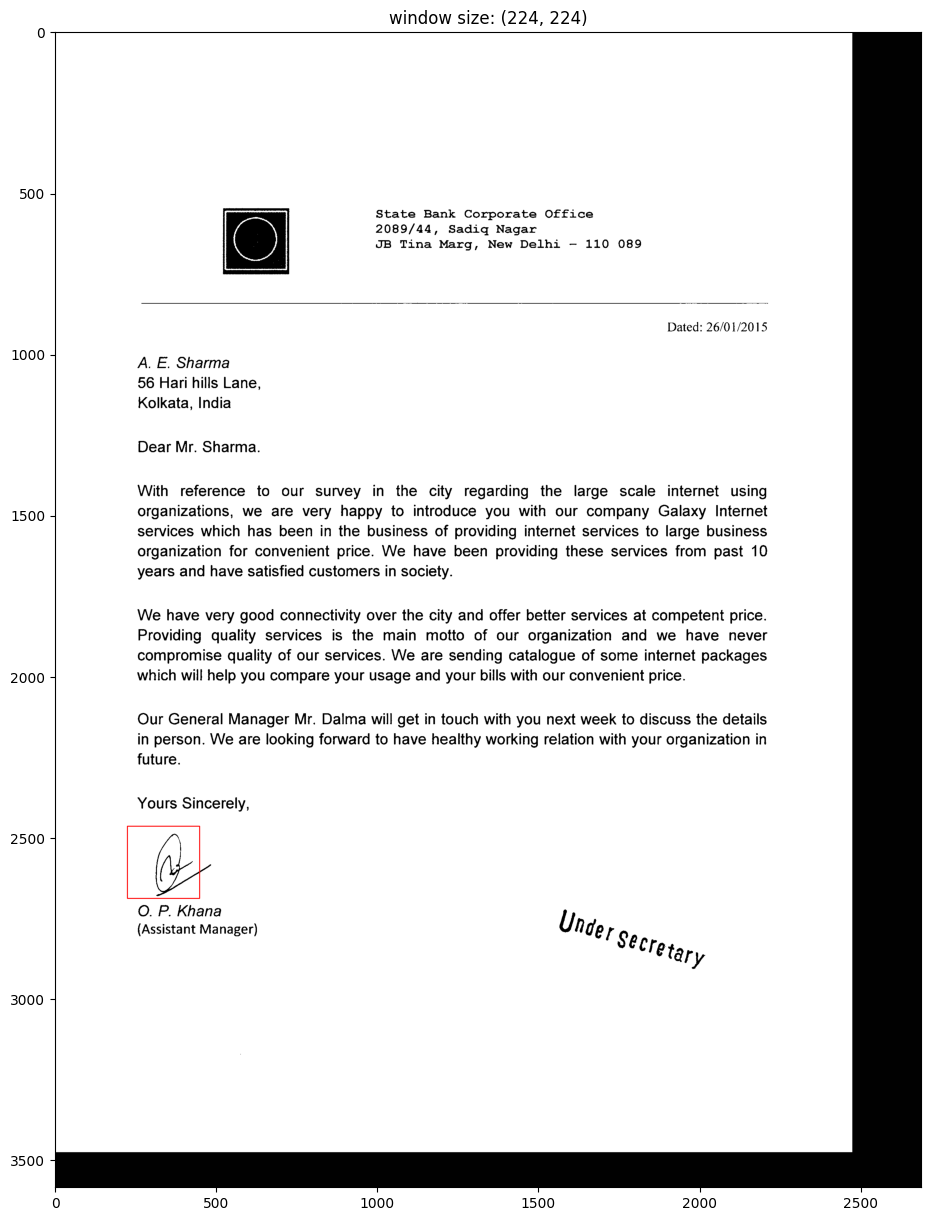

In [88]:
images = ["SPODS_Dataset/image (790).png"]
windows = [(224,224)]
for image in images:
  image = cv2.imread(image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  ret, image = cv2.threshold(image, 160, 255, cv2.THRESH_BINARY)
  image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
  for window in windows:
    image_copy = image.copy()
    image_copy = divide_image_into_parts_with_hist(image_copy, window,threshold=0.9)
    plt.figure(figsize=(15, 15))
    plt.imshow((image_copy).astype(np.uint8))
    plt.title(f"window size: {window}")
  plt.show()

